In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import torch
import torch.nn as nn
import torchvision 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import pandas as pd
import pdb
import os
import shutil
import pyrealsense2 as rs
device= 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [45]:

def tranform_tensor(point, center,scale, resolution, inverse=False):

    _pt = torch.tensor([point[0],point[1],1]).view(-1,1).type(torch.FloatTensor)

    h = 200 * scale
    t = torch.eye(3).repeat(len(scale),1,1)
    t[:,0,0] = resolution / h
    t[:,1,1] = resolution / h
    t[:,0,2] = resolution *(-center[:,0]/h + 0.5)
    t[:,1,2] = resolution *(-center[:,1]/h + 0.5)
    if inverse:
        t = torch.inverse(t)

    return torch.matmul(t,_pt)

def crop_and_resize_tensor(imgs, center, scale, resolution=256):
    """"
    function that crops and resizes a batch of images using a center and scale 
    Arguments:
        image {torch.tensor} -- a batch of images. N,C,H,W 
        center {torch.tensor} -- the center of the object, usually the same as of the bounding box
        scale {torch.tensor} -- scale of the face
    Keyword Arguments:
        resolution {float} -- the size of the output cropped image (default: {256.0})
    Returns:
        image {torch.tensor} -- a batch of cropped images. N,C,H,W 
    """
    #todo -- make this work in a batch...
    
    #current size
    N,C,H,W = imgs.shape
    ul_b = tranform_tensor([1,1],center,scale, resolution, inverse = True)
    br_b = tranform_tensor([resolution,resolution],center,scale, resolution, inverse = True)
    out_imgs = torch.zeros((N,C,resolution,resolution))
    for image, ul_t,bl_t, k in zip(imgs,ul_b,br_b, range(N)):
        ul=np.round(ul_t.numpy(),0).astype(np.int)
        br=np.round(bl_t.numpy(),0).astype(np.int)
        newImg = torch.zeros([C,int(br[1]-ul[1]),int(br[0]-ul[0])]).int()
        newX = np.array(
        [max(1, -ul[0] + 1), min(br[0], W) - ul[0]], dtype=np.int32)
        newY = np.array(
        [max(1, -ul[1] + 1), min(br[1], H) - ul[1]], dtype=np.int32)
        oldX = np.array([max(1, ul[0] + 1), min(br[0], W)], dtype=np.int32)
        oldY = np.array([max(1, ul[1] + 1), min(br[1], H)], dtype=np.int32)
        
        #newImg[:,int(newY[0]) - 1:int(newY[1]), int(newX[0]) - 1:int(newX[1])
        #   ] = image[:,int(oldY[0]) - 1:int(oldY[1]), int(oldX[0]) - 1:int(oldX[1])]
        
        newImg[:,int(newY[0]):int(newY[1]), int(newX[0]):int(newX[1])] = image[:,int(oldY[0]):int(oldY[1]), int(oldX[0]):int(oldX[1])]
        out_imgs[k] = nn.functional.interpolate(newImg.unsqueeze_(0).float(), size=(resolution, resolution))
        
        
        
    return out_imgs
    
   # new_image = torch.zeros((N,C,))

def _descale(p, s): return (0.5*(p+1.))*s 

In [46]:
#face detector 
from arch.net_blazeface import BlazeFace
face_detector = BlazeFace()
face_detector.load_state_dict(torch.load('/home/deniz/Code/ClinicalScore/share_mobilenet/pretrained_models/blazeface.pth'))
face_detector.load_anchors_from_npy(np.load('/home/deniz/Code/ClinicalScore/share_mobilenet/pretrained_models/anchors.npy'), device)
#Move model to gpu or cpu 
face_detector.to(device);
#tell Pytorch that you will use the model -- not train the model 
face_detector.eval();

In [47]:
#landmarks finder
from arch.MobileNetV2 import mobilenet_v2
from arch.softargmax import SpatialSoftArgmax2d
class HeadBlock(nn.Module):
    def __init__(self, in_channels, proj_channels, out_channels, **kwargs):
        super(HeadBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, proj_channels, 1, bias=False),
            nn.BatchNorm2d(proj_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(proj_channels, out_channels, 1, bias=False),
            )
        
        self.softargmax = SpatialSoftArgmax2d()
        
    def forward(self, input):
        out = []
        out.append(self.layers(input))
        out.append(self.softargmax(out[-1]))
        return out
    
backbone = mobilenet_v2()
nopoints = 68
head = HeadBlock(152, 152, nopoints)
model_mobilenet = nn.Sequential(backbone, head)
model_mobilenet.load_state_dict(torch.load('/home/deniz/Code/ClinicalScore/share_mobilenet/code/models/models_MobineNet_300W_softmax_pretrainedImagenet/FineTuned_TorontoNeuroFace_Epoch_11.pth'), strict=False)
model_mobilenet.eval();
model_mobilenet.to(device);

In [48]:
avi_path = r'/media/deniz/easystore/facial_tracking_data_2021/mobileNet_lookups.csv'
avi_df = pd.read_csv(avi_path)
avi_df = avi_df.drop("Unnamed: 0", axis=1)
avi_df.head()

subject    task      date                                           avi_path
0    AF01    OPEN  20170509  /media/deniz/easystore/facial_tracking_data_20...
1    AF01    OPEN  20170509  /media/deniz/easystore/facial_tracking_data_20...
2    AF01  SPREAD  20170509  /media/deniz/easystore/facial_tracking_data_20...
3    AF01  SPREAD  20170509  /media/deniz/easystore/facial_tracking_data_20...
4    AF01  PUCKER  20170509  /media/deniz/easystore/facial_tracking_data_20...

In [49]:

population = ['ALS', 'PLS', 'Kennedys', 'Post-stroke', 'Healthy_Control']

tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE' , 'RST_REST', 'NSM_KISS', 'NSM_PUCKER', 'DDK_PA']


base_path = '/media/deniz/easystore/facial_tracking_data_2021'
output_subfolder = 'LANDMARKS/mobileNet'
sufix = '_landmarksPixels2D.csv'

In [50]:
st=time.time()
#transforms 
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])


error_avi = []

for index, row in avi_df.iterrows():
     
    
    color_file = row['avi_path']
    
    
    print('Starting: ', color_file)
    print()
    splited_name = color_file.split('/')
    name = splited_name[-1][:-4]
    root_path = '/'.join(splited_name[:-2])
    
    folder  = os.path.join(root_path,output_subfolder)
    csv_name = os.path.join(folder, name + sufix)
    
    if os.path.exists(csv_name):
        continue 
        
    if not os.path.exists(folder):
        os.makedirs(folder)
    vid = torchvision.io.read_video(color_file, pts_unit='sec')
    
    
    try: 
        #create batches
        idx = np.arange(vid[0].shape[0])
        batch_size=200
        q = int(idx.shape[0] / batch_size)
        block_end = q * batch_size
        batch_idx = np.split(idx[:block_end], q) + [idx[block_end:]]

        F,H,W,C = vid[0].shape
        landmarks = np.zeros((F,68,2))
        o_landmarks = np.zeros((F,68,2))
        c = np.zeros((F,2))
        s = np.zeros((F,))
        #this for facial localization 
        des_dim = 128
        yshift, xshift = 0, (H-W)//2
        xstart = (int(W*(128/H))-des_dim)//2

        ref_scale = 195 #adjust this value to have the face smaller or bigger in the image
        resolution = 256
        vid_crop = torch.zeros((F,C,resolution,resolution))

        with torch.no_grad():
            for batch in batch_idx:

                imgs = vid[0][batch,:,:,:]
                imgs = imgs.permute(0,3,1,2)#.type(torch.FloatTensor)
                imgs_bf = nn.functional.interpolate(imgs, (des_dim, int(W*(des_dim/H))))
                imgs_bf = imgs_bf[:,:,:, xstart:xstart+128]

                bboxes = torch.cat(face_detector.predict_on_batch(imgs_bf.to(device)))
                face_locs = torch.cat((bboxes[:,1:2], bboxes[:,0:1], bboxes[:,3:4], bboxes[:,2:3]), dim=1) * H + torch.tensor([int((W-H)/2), 0, int((W-H)/2), 0]) 


                centersx = face_locs[:,2] - (face_locs[:,2]-face_locs[:,0])/2
                centersy = (face_locs[:,3] - (face_locs[:,3]-face_locs[:,1])/2) - (face_locs[:,3]-face_locs[:,1])*0.12
                centers = torch.cat((centersx.view(-1,1),centersy.view(-1,1)), dim=1)

                scales = ((face_locs[:,2]-face_locs[:,0]) + (face_locs[:,3]-face_locs[:,1]))/ref_scale

                #if using FAN, do this
                #imgs_norm = (imgs.div_(255)
                #if using other models do this


                imgs_crop = crop_and_resize_tensor(imgs, centers, scales, resolution=resolution)
                vid_crop[batch] = imgs_crop
                imgs_crop = (imgs_crop.div(255)-MEAN[None,:,None,None]) / STD[None,:,None,None]

                outs = model_mobilenet(imgs_crop.to(device))
                landmarks[batch,:,:] = outs[-1].cpu().numpy()
                c[batch,:] = centers.cpu().numpy()
                s[batch] = scales.cpu().numpy()

        landmarks = _descale(landmarks,resolution)


        
        for f in range(landmarks.shape[0]):

            h = 200 * s[f]
            t = torch.eye(3)
            t[0,0] = resolution / h
            t[1,1] = resolution / h
            t[0,2] = resolution *(-c[f,0]/h + 0.5)
            t[1,2] = resolution *(-c[f,1]/h + 0.5)
            t = torch.inverse(t)

            for l in range(landmarks.shape[1]):
                point = landmarks[f,l,:]
                _pt = torch.tensor([point[0],point[1],1]).view(-1,1).type(torch.FloatTensor)

                original = torch.matmul(t,_pt)
                print(original.shape)
                original =  original[0:-1,:]
                original = original.reshape(2,)
                print(original.shape)
                o_landmarks[f,l,:] = original


        #create a dataframe that will store all the information 
        df_cols = []
        #y_col = []
        #x_col = []
        for i in range(0,68):
            num=str(i)
            xx = 'landmark_'+num+'_x'
            yy = 'landmark_'+num+'_y'
            #x_col.append(xx)
            #y_col.append(yy)
            df_cols.append(xx)
            df_cols.append(yy)
        l = o_landmarks.reshape(o_landmarks.shape[0],-1)
        LandmarkDataFrame = pd.DataFrame(l,columns = df_cols)
        LandmarkDataFrame["fps"]=vid[2].get('video_fps')
        LandmarkDataFrame.to_csv(csv_name)
        
    except:
        print("ERROR OCCURTED")
        print()
        error_avi.append(color_file)
        pass
   

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_OPEN_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_OPEN_depth.avi

ERROR OCCURTED

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_SPREAD_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_SPREAD_depth.avi

ERROR OCCURTED

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_KISS_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF02_SBK_20170517/02/RSSDK/AF02_02_20170517_NSM_OPEN_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF02_SBK_20170517/02/RSSDK/AF02_02_20170517_NSM_KISS_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF02

Bits overconsumption: 10936 > 10928


ERROR OCCURTED

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF07_SBK_20170530/02/RSSDK/AF07_02_20170530_NSM_SPREAD_depth.avi

ERROR OCCURTED

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF07_SBK_20170530/02/RSSDK/AF07_02_20170530_NSM_KISS_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF08_SBK_20170606/02/RSSDK/AF08_02_20170606_NSM_KISS_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF08_SBK_20170606/02/RSSDK/AF08_02_20170606_NSM_OPEN_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF08_SBK_20170606/02/RSSDK/AF08_02_20170606_NSM_OPEN_depth.avi

ERROR OCCURTED

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF08_SBK_20170606/02/RSSDK/AF08_02_20170606_NSM_SPREAD_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF08_SBK_20170606/02/RSSDK/AF08_02_20170606_NSM_SPREAD_depth.avi

ERROR OCCURTED

Starting:  /media/deniz/easystore/

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Kennedys/K001_SBK_20190621/02/RSSDK/K001_02_20190621_NSM_OPEN_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Kennedys/K001_SBK_20190621/02/RSSDK/K001_02_20190621_NSM_PUCKER_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Kennedys/K003_SBK_20190809/02/RSSDK/K003_02_20190809_NSM_BIGSMILE_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Kennedys/K003_SBK_20190809/02/RSSDK/K003_02_20190809_NSM_OPEN_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Kennedys/K003_SBK_20190809/02/RSSDK/K003_02_20190809_NSM_PUCKER_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Kennedys/K003_SBK_20190809/02/RSSDK/K003_02_20190809_NSM_SPREAD_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP07_SBK_20191018/02/RSSDK/OP07_02_20191018_NSM_BIGSMILE_color.avi

Starting:  /media/deniz/easystore/facial_tracking_da

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP05_SBK_20190830/02/RSSDK/OP05_02_20190830_NSM_SPREAD_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP05_SBK_20190926/02/RSSDK/OP05_02_20190926_NSM_SPREAD_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP05_SBK_20190926/02/RSSDK/OP05_02_20190926_NSM_OPEN_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP05_SBK_20190926/02/RSSDK/OP05_02_20190926_NSM_PUCKER_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP05_SBK_20190926/02/RSSDK/OP05_02_20190926_NSM_BIGSMILE_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP06_SBK_20190823/02/RSSDK/OP06_02_20190823_NSM_BIGSMILE_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP06_SBK_20190823/02/RSSDK/OP06_02_20190823_NSM_PUCKER_color.avi

Starting:  /media/deniz/easystor

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP12_SBK_20190926/02/RSSDK/OP12_02_20190926_NSM_SPREAD_color.avi

ERROR OCCURTED

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP12_SBK_20190926/02/RSSDK/OP12_02_20190926_NSM_BIGSMILE_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP12_SBK_20190926/02/RSSDK/OP12_02_20190926_NSM_OPEN_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP12_SBK_20190926/02/RSSDK/OP12_02_20190926_NSM_PUCKER_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP12_SBK_20191107/02/RSSDK/OP12_02_20191107_NSM_SPREAD_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP12_SBK_20191107/02/RSSDK/OP12_02_20191107_NSM_BIGSMILE_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP12_SBK_20191107/02/RSSDK/OP12_02_20191107_NSM_OPEN_color.avi

Starting:  /media/

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/S002_TRI_20170707/02/RSSDK/S002_02_20170707_NSM_OPEN_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/S002_TRI_20170707/02/RSSDK/S002_02_20170707_NSM_OPEN_depth.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/S002_TRI_20170707/02/RSSDK/S002_02_20170707_NSM_SPREAD_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/S002_TRI_20170707/02/RSSDK/S002_02_20170707_NSM_SPREAD_depth.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/S003_TRI_20170728/02/RSSDK/S003_02_20170728_NSM_KISS_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/S003_TRI_20170728/02/RSSDK/S003_02_20170728_NSM_OPEN_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Post-stroke/S003_TRI_20170728/02/RSSDK/S003_02_20170728_NSM_OPEN_depth.avi

Starting:  /media/deniz/easystore/facial_tra

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF01_SBK_20170515/02/RSSDK/NF01_02_20170515_NSM_OPEN_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF01_SBK_20170515/02/RSSDK/NF01_02_20170515_NSM_OPEN_depth.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF01_SBK_20170515/02/RSSDK/NF01_02_20170515_NSM_SPREAD_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF01_SBK_20170515/02/RSSDK/NF01_02_20170515_NSM_SPREAD_depth.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF02_SBK_20170517/02/RSSDK/NF02_02_20170517_NSM_KISS_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF02_SBK_20170517/02/RSSDK/NF02_02_20170517_NSM_OPEN_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF02_SBK_20170517/02/RSSDK/NF02_02_20170517_NSM_OPEN_depth.avi

Starting:  /medi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF15_TRI_20190826/02/RSSDK/NF15_02_20190826_NSM_BIGSMILE_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF15_TRI_20190826/02/RSSDK/NF15_02_20190826_NSM_BIGSMILE_color.mp4

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF15_TRI_20190826/02/RSSDK/NF15_02_20190826_NSM_BIGSMILE_colorlandmark.mp4

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF15_TRI_20190826/02/RSSDK/NF15_02_20190826_NSM_OPEN_1417_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF15_TRI_20190826/02/RSSDK/NF15_02_20190826_NSM_OPEN_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF15_TRI_20190826/02/RSSDK/NF15_02_20190826_NSM_PUCKER_1420_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF15_TRI_20190826/02/RSSDK/NF15_02_20190826_NSM_SPRE

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20200214/02/RSSDK/NF20_02_20200214_NSM_OPEN_1444_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20200214/02/RSSDK/NF20_02_20200214_NSM_PUCKER_1446.mp4

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20200214/02/RSSDK/NF20_02_20200214_NSM_SPREAD_1445.mp4

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20200214/02/RSSDK/NF20_02_20200214_NSM_SPREAD_1445_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20200214/02/RSSDK/NF20_02_20200214_NSM_BIGSMILE_1445.mp4

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF20_TRI_20200214/02/RSSDK/NF20_02_20200214_NSM_BIGSMILE_1445_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF21_TRI_20190715/02/RSSDK/NF21_02_20190715_NSM_BIGSMILE_c

ERROR OCCURTED

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20200218/02/RSSDK/NF26_02_20200218_NSM_BIGSMILE_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20200218/02/RSSDK/NF26_02_20200218_NSM_OPEN_1419_1.mp4

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF26_TRI_20200218/02/RSSDK/NF26_02_20200218_NSM_OPEN_1419_1_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF27_TRI_20190912/02/RSSDK/NF27_02_20190912_NSM_BIGSMILE_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF27_TRI_20190912/02/RSSDK/NF27_02_20190912_NSM_OPEN_color.avi

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF27_TRI_20190912/02/RSSDK/NF27_02_20190912_NSM_OPEN_color.mp4

Starting:  /media/deniz/easystore/facial_tracking_data_2021/Healthy_Control/NF27_TRI_20190912/02/RSSDK/NF27_02_20190912_NSM_SPRE

In [51]:
print(len(error_avi))
error_avi

17


['/media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_OPEN_depth.avi',
 '/media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_SPREAD_depth.avi',
 '/media/deniz/easystore/facial_tracking_data_2021/ALS/AF07_SBK_20170530/02/RSSDK/AF07_02_20170530_NSM_SPREAD_color.avi',
 '/media/deniz/easystore/facial_tracking_data_2021/ALS/AF07_SBK_20170530/02/RSSDK/AF07_02_20170530_NSM_SPREAD_depth.avi',
 '/media/deniz/easystore/facial_tracking_data_2021/ALS/AF08_SBK_20170606/02/RSSDK/AF08_02_20170606_NSM_OPEN_depth.avi',
 '/media/deniz/easystore/facial_tracking_data_2021/ALS/AF08_SBK_20170606/02/RSSDK/AF08_02_20170606_NSM_SPREAD_depth.avi',
 '/media/deniz/easystore/facial_tracking_data_2021/ALS/AF09_SBK_20170613/02/RSSDK/AF09_02_20170613_NSM_OPEN_depth.avi',
 '/media/deniz/easystore/facial_tracking_data_2021/ALS/AF09_SBK_20170613/02/RSSDK/AF09_02_20170613_NSM_SPREAD_depth.avi',
 '/media/deniz/easystore/facia

In [21]:
path = r'/media/deniz/easystore/facial_tracking_data_2021/mobileNet_error_files.csv'

df = pd.DataFrame(error_avi,columns =['error_avi'])

df.to_csv(path)


# Get 3d VALUES 

In [ ]:
# working get 3D metric values of the 68 landmarks 

def get3dlandmarks(BAG_File, info_file, csv_file):

    DF_landmarks = pd.read_csv(csv_file, index_col=0)

    DF_info = pd.read_csv(info_file, index_col=0)


    # create dataframe to store information about 3d position of landmarks
    df_cols_p1 = ['Time_Stamp (s)']
    for i in range(0, 68):
        num = str(i)
        xx = 'landmark_' + num
        df_cols_p1.append(xx)
        df_cols_p1.append(xx)
        df_cols_p1.append(xx)

    df_cols_p2 = [""]
    for i in range(0, 68):
        df_cols_p2.append("x")
        df_cols_p2.append("y")
        df_cols_p2.append("z")

    header = [np.array(df_cols_p1),
              np.array(df_cols_p2)]

    DF_3dpositions = pd.DataFrame(columns=header)

    DF_3dpositions['Time_Stamp (s)'] = DF_info['Frame_Time_Stamp']
    #DF_3dpositions['Video_Frame_number'] = DF_landmarks['Video_Frame_number']

    # start the process of extracting the video information for each video
    pipeline = rs.pipeline()
    config = rs.config()

    rs.config.enable_device_from_file(config, BAG_File, repeat_playback=False)

    config.enable_all_streams()
    profile = pipeline.start(config)

    # create alignment object
    align_to = rs.stream.color
    align = rs.align(align_to)

    # Getting the depth sensor's depth scale (see rs-align example for explanation)
    depth_sensor = profile.get_device().first_depth_sensor()
    depth_scale = depth_sensor.get_depth_scale()

    # inform the device that this is not live streaming from camera
    playback = profile.get_device().as_playback()
    playback.set_real_time(False)
    duration = playback.get_duration()

    # fill holes in the depth information (based on this example: https://nbviewer.jupyter.org/github/IntelRealSense/librealsense/blob/jupyter/notebooks/depth_filters.ipynb)
    spatial = rs.spatial_filter()
    spatial.set_option(rs.option.filter_magnitude, 2)
    spatial.set_option(rs.option.filter_smooth_alpha, 0.5)
    spatial.set_option(rs.option.filter_smooth_delta, 20)
    spatial.set_option(rs.option.holes_fill, 3)

    true_frame_number = []
    frame_number = []
    time_st = []

    num_frame = 0

    try:
        while True:
            frames = pipeline.wait_for_frames()

            this_frame = frames.get_frame_number()  # get frame number        
            landmarks=None
            # verify that we have landmarks for this particular frame

            try:
                vid_frame = DF_info.Frame_Number_in_Video.loc[DF_info["BAG_Frame_Number"]==this_frame].values[0] 

                index_ = DF_info.index[DF_info['BAG_Frame_Number']==this_frame]

                landmarks = DF_landmarks.iloc[index_].values[0][:-1]
                #print(landmarks)
                landmarks = landmarks.astype('float').reshape(-1, 2)
                aligned_frames = align.process(frames)

                # take color and depth from frame, if any to these is not available then skip the frame
                aligned_frames = align.process(frames)

                # take color and depth from frame, if any to these is not available then skip the frame
                aligned_depth = aligned_frames.get_depth_frame()
                aligned_color = aligned_frames.get_color_frame()

                # validate that both frames are available
                if not aligned_depth or not aligned_color:
                    continue

                #time_stamp = frames.get_timestamp()
                #true_frame_number.append(frames.get_frame_number())
                #time_st.append(time_stamp)
                #frame_number.append(num_frame)

                # Intrinsics & Extrinsics
                depth_intrin = aligned_depth.profile.as_video_stream_profile().intrinsics
                color_intrin = aligned_depth.profile.as_video_stream_profile().intrinsics
                depth_to_color_extrin = aligned_depth.profile.get_extrinsics_to(aligned_color.profile)

                aligned_filtered_depth = spatial.process(aligned_depth)
                depth_frame_array = np.asanyarray(aligned_filtered_depth.as_frame().get_data())
                depth_frame_array = depth_frame_array * depth_scale

                coords = []

                for (c,
                     r) in landmarks:  # landmarks provide the x,y position of each landmark. x are columns and y are rows in the figure
                    # depth_value = depth_frame.get_distance(int(c),int(r))
                    # x,y,z = rs.rs2_deproject_pixel_to_point(depth_intrin, [int(c), int(r)], depth_value)
                    try:
                        depth_value = depth_frame_array[int(r), int(c)]
                    except IndexError:
                        h,w = depth_frame_array.shape
                        if r>w-1:r=h-1
                        if c>h-1:c=w-1
                        depth_value = depth_frame_array[int(r), int(c)]

                    z = depth_value
                    x = z * ((c - depth_intrin.ppx) / depth_intrin.fx)
                    y = z * ((r - depth_intrin.ppy) / depth_intrin.fy)
                    coords.append(x), coords.append(y), coords.append(z)

                DF_3dpositions.loc[index_,1:] =coords
                
            except IndexError:
                error= 'Error file:' + BAG_File.split(os.path.sep)[-1] +'\n' + str(this_frame)+' does not exists in color video'
                print(error)


    except RuntimeError:
        pass
    finally:
        pipeline.stop()
        
    DF_3dpositions['depth_scale'] = depth_scale  
    landmark_file = csv_file[:-4]+'3D.csv'
    DF_3dpositions.to_csv(landmark_file)

# On a single case do a check 

In [42]:
# Reading the fine tuned fan x and y pixel values

fan_pixel_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/LANDMARKS/Diego_FaceData/landmarks_finetuned_w15/A001_02_20170509_NSM_OPEN_landmarks.csv'
df = pd.read_csv(fan_pixel_path, index_col=0)

print(len(df))

for col in df.columns:
    if 'bbox'in col or 'Time' in col:
        df = df.drop([col], axis = 1)

x_fan = df
y_fan = df
for col in df.columns:
    if 'y'in col:
        x_fan = x_fan.drop([col], axis = 1)
    elif 'x' in col:
        y_fan = y_fan.drop([col], axis = 1)
        
x_fan.head()

506


Video_Frame_number  landmark_0_x  landmark_1_x  landmark_2_x  landmark_3_x  \
0                   0         250.0         250.0         252.0         253.0   
1                   1         252.0         250.0         253.0         255.0   
2                   2         250.0         249.0         250.0         253.0   
3                   3         250.0         249.0         250.0         253.0   
4                   4         250.0         250.0         252.0         253.0   

   landmark_4_x  landmark_5_x  landmark_6_x  landmark_7_x  landmark_8_x  ...  \
0         260.0         272.0         286.0         304.0         328.0  ...   
1         260.0         272.0         287.0         305.0         328.0  ...   
2         260.0         271.0         286.0         304.0         328.0  ...   
3         259.0         271.0         286.0         304.0         328.0  ...   
4         260.0         271.0         286.0         304.0         328.0  ...   

   landmark_58_x  landmark_59_x  landmark_60_x  landmark_61_x  landmark_62_x  \
0          315.0          305.0          300.0          313.0          325.0   
1          314.0          304.0          300.0          312.0          325.0   
2          314.0          305.0          300.0          313.0          325.0   
3          315.0          305.0          300.0          313.0          326.0   
4          315.0          305.0          300.0          313.0          325.0   

   landmark_63_x  landmark_64_x  landmark_65_x  landmark_66_x  landmark_67_x  
0          339.0          353.0          338.0          326.0          313.0  
1          339.0          353.0          338.0          325.0          312.0  
2          339.0          353.0          338.0          325.0          313.0  
3          339.0          353.0          338.0          326.0          313.0  
4          339.0          352.0          338.0          325.0          313.0  

[5 rows x 69 columns]

In [43]:
# Reading the mobileNet x and y pixel values

mnet_pixel_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/LANDMARKS/mobileNet/AF01_02_20170509_NSM_OPEN_color_landmarksPixels2D.csv'
df2 = pd.read_csv(mnet_pixel_path, index_col=0)

print(len(df2))


x_mnet = df2
y_mnet = df2
for col in df2.columns:
    if 'y'in col:
        x_mnet = x_mnet.drop([col], axis = 1)
    elif 'x' in col:
        y_mnet = y_mnet.drop([col], axis = 1)
        
x_mnet.head()

506


landmark_0_x  landmark_1_x  landmark_2_x  landmark_3_x  landmark_4_x  \
0     64.734978     64.708374     65.648548     68.599319     72.821159   
1     67.089706     67.475899     69.009804     71.865654     75.710869   
2     64.702038     64.681038     65.745373     68.767395     72.786964   
3     64.264717     64.632668     65.916893     68.736919     72.800140   
4     66.435001     66.759769     68.155045     70.502022     74.391434   

   landmark_5_x  landmark_6_x  landmark_7_x  landmark_8_x  landmark_9_x  ...  \
0     80.500504     92.912918    109.073751    126.081367    144.438469  ...   
1     82.706238     94.073502    108.639582    125.150607    143.877001  ...   
2     80.387680     91.892509    107.738106    125.291043    143.563597  ...   
3     80.517250     92.688362    108.035973    125.257994    143.455190  ...   
4     81.463463     93.387085    108.857712    125.476750    143.918292  ...   

   landmark_59_x  landmark_60_x  landmark_61_x  landmark_62_x  landmark_63_x  \
0     106.819351     103.514862     112.241232     122.647982     133.641408   
1     108.650045     104.414747     114.580284     124.725576     134.742279   
2     108.393036     103.674549     113.567644     123.286976     133.397634   
3     106.977509     103.476910     112.373669     122.449317     133.464484   
4     109.108902     105.160435     113.895132     124.177763     134.008546   

   landmark_64_x  landmark_65_x  landmark_66_x  landmark_67_x        fps  
0     142.886788     132.740615     122.657430     113.111897  48.501478  
1     144.947807     134.402648     125.097038     115.328079  48.501478  
2     142.560751     132.953867     123.345821     114.453179  48.501478  
3     143.176632     132.475258     122.699217     113.519384  48.501478  
4     144.051489     133.507376     124.340100     115.090283  48.501478  

[5 rows x 69 columns]

In [ ]:
# EXAMPLE OF PLOTTING 

frame_number = 540

amount_of_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
#cap.set(cv2.CAP_PROP_FRAME_COUNT, frame_number-1)
cap.set(1, 300)
ret, frame = cap.read()
print(amount_of_frames)
print(cap)
print(frame.shape)
window_name = 'image'
#gray = cv2.cvtColor(frame, cv2.COLOR_RGBA2RGB)
#cv2.imshow(window_name, frame)
plt.axis("off")
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#plt.imshow(frame)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.scatter(x.iloc[300][1:],y.iloc[300][1:], label='SBR')
plt.scatter(x_fan.iloc[300][1:],y_fan.iloc[300][1:], label='FAN')
for i in range(len(x.iloc[300].values)):
    if i == 0:
        continue 
    plt.text(x.iloc[300].values[i], y.iloc[300].values[i], str(i))

plt.legend()

In [ ]:
# read and modify the video 

vid = torchvision.io.read_video(r"/media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_OPEN_color.avi", pts_unit='sec')
imgs = vid[0][:,:,:,:]
imgs = imgs.permute(0,3,1,2)
#imgs_crop = crop_and_resize_tensor(imgs, centers, scales, resolution=resolution)
#imgs_crop = (imgs_crop.div(255)-MEAN[None,:,None,None]) / STD[None,:,None,None]

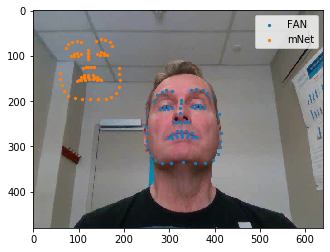

In [57]:
%matplotlib inline
n = 270
plt.imshow(imgs[n].permute(1,2,0)/255)


plt.scatter(x_fan.iloc[n][1:],y_fan.iloc[n][1:],s=5, label='FAN')
plt.scatter(x_mnet.iloc[n][1:-1],y_mnet.iloc[n][1:-1],s=5, label='mNet')
#plt.scatter(landmarks[n,:,0], landmarks[n,:,1],s=5, color='red')
plt.legend()

# Get the 3d metric measures 

In [20]:
def get3dlandmarks(BAG_File, info_file, csv_file):

    DF_landmarks = pd.read_csv(csv_file, index_col=0)

    DF_info = pd.read_csv(info_file, index_col=0)


    # create dataframe to store information about 3d position of landmarks
    df_cols_p1 = ["Video_Frame_number", 'Time_Stamp (s)']
    for i in range(0, 68):
        num = str(i)
        xx = 'landmark_' + num
        df_cols_p1.append(xx)
        df_cols_p1.append(xx)
        df_cols_p1.append(xx)

    df_cols_p2 = ["",""]
    for i in range(0, 68):
        df_cols_p2.append("x")
        df_cols_p2.append("y")
        df_cols_p2.append("z")

    header = [np.array(df_cols_p1),
              np.array(df_cols_p2)]

    DF_3dpositions = pd.DataFrame(columns=header)

    DF_3dpositions['Time_Stamp (s)'] = DF_landmarks['Time_Stamp (s)']
    DF_3dpositions['Video_Frame_number'] = DF_landmarks['Video_Frame_number']

    # start the process of extracting the video information for each video
    pipeline = rs.pipeline()
    config = rs.config()

    rs.config.enable_device_from_file(config, BAG_File, repeat_playback=False)

    config.enable_all_streams()
    profile = pipeline.start(config)

    # create alignment object
    align_to = rs.stream.color
    align = rs.align(align_to)

    # Getting the depth sensor's depth scale (see rs-align example for explanation)
    depth_sensor = profile.get_device().first_depth_sensor()
    depth_scale = depth_sensor.get_depth_scale()

    # inform the device that this is not live streaming from camera
    playback = profile.get_device().as_playback()
    playback.set_real_time(False)
    duration = playback.get_duration()

    # fill holes in the depth information (based on this example: https://nbviewer.jupyter.org/github/IntelRealSense/librealsense/blob/jupyter/notebooks/depth_filters.ipynb)
    spatial = rs.spatial_filter()
    spatial.set_option(rs.option.filter_magnitude, 2)
    spatial.set_option(rs.option.filter_smooth_alpha, 0.5)
    spatial.set_option(rs.option.filter_smooth_delta, 20)
    spatial.set_option(rs.option.holes_fill, 3)

    true_frame_number = []
    frame_number = []
    time_st = []

    num_frame = 0

    try:
        while True:
            frames = pipeline.wait_for_frames(100)

            this_frame = frames.get_frame_number()  # get frame number        
            landmarks=None
            # verify that we have landmarks for this particular frame

            try:
                vid_frame = DF_info.Frame_Number_in_Video.loc[DF_info["BAG_Frame_Number"]==this_frame].values[0] 

                index_ = DF_info.index[DF_info['BAG_Frame_Number']==this_frame]

                landmarks = DF_landmarks.iloc[index_].values[0][6:]   
                landmarks = landmarks.astype('float').reshape(-1, 2)
                aligned_frames = align.process(frames)

                # take color and depth from frame, if any to these is not available then skip the frame
                aligned_frames = align.process(frames)

                # take color and depth from frame, if any to these is not available then skip the frame
                aligned_depth = aligned_frames.get_depth_frame()
                aligned_color = aligned_frames.get_color_frame()

                # validate that both frames are available
                if not aligned_depth or not aligned_color:
                    continue

                #time_stamp = frames.get_timestamp()
                #true_frame_number.append(frames.get_frame_number())
                #time_st.append(time_stamp)
                #frame_number.append(num_frame)

                # Intrinsics & Extrinsics
                depth_intrin = aligned_depth.profile.as_video_stream_profile().intrinsics
                color_intrin = aligned_depth.profile.as_video_stream_profile().intrinsics
                depth_to_color_extrin = aligned_depth.profile.get_extrinsics_to(aligned_color.profile)

                aligned_filtered_depth = spatial.process(aligned_depth)
                depth_frame_array = np.asanyarray(aligned_filtered_depth.as_frame().get_data())
                depth_frame_array = depth_frame_array * depth_scale

                coords = []

                for (c,
                     r) in landmarks:  # landmarks provide the x,y position of each landmark. x are columns and y are rows in the figure
                    # depth_value = depth_frame.get_distance(int(c),int(r))
                    # x,y,z = rs.rs2_deproject_pixel_to_point(depth_intrin, [int(c), int(r)], depth_value)
                    try:
                        depth_value = depth_frame_array[int(r), int(c)]
                    except IndexError:
                        h,w = depth_frame_array.shape
                        if r>w-1:r=h-1
                        if c>h-1:c=w-1
                        depth_value = depth_frame_array[int(r), int(c)]

                    z = depth_value
                    x = z * ((c - depth_intrin.ppx) / depth_intrin.fx)
                    y = z * ((r - depth_intrin.ppy) / depth_intrin.fy)
                    coords.append(x), coords.append(y), coords.append(z)

                DF_3dpositions.loc[index_,2:] =coords
            except IndexError:
                error= 'Error file:' + BAG_File.split(os.path.sep)[-1] +'\n' + str(this_frame)+' does not exists in color video'
                print(error)


    except RuntimeError:
        pass
    finally:
        pipeline.stop()
        
        
    landmark_file = csv_file[:-4]+'3D.csv'
    DF_3dpositions.to_csv(landmark_file)



In [ ]:
get3dlandmarks(BAG_File, info_file, csv_file)

In [10]:
st=time.time()
#transforms 
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])


error_avi = []

for index, row in avi_df.iterrows():
     
    
    color_file = row['avi_path']
    
    print('Starting: ', color_file)
    print()
    splited_name = color_file.split('/')
    name = splited_name[-1][:-4]
    root_path = '/'.join(splited_name[:-2])
    
    folder  = os.path.join(root_path,output_subfolder)
    csv_name = os.path.join(folder, name + sufix)
    
    if not os.path.exists(folder):
        os.makedirs(folder)
    vid = torchvision.io.read_video(color_file, pts_unit='sec')
    
    
    try: 
        #create batches
        idx = np.arange(vid[0].shape[0])
        batch_size=200
        q = int(idx.shape[0] / batch_size)
        block_end = q * batch_size
        batch_idx = np.split(idx[:block_end], q) + [idx[block_end:]]

        F,H,W,C = vid[0].shape
        landmarks = np.zeros((F,68,2))
        #this for facial localization 
        des_dim = 128
        yshift, xshift = 0, (H-W)//2
        xstart = (int(W*(128/H))-des_dim)//2

        ref_scale = 195 #adjust this value to have the face smaller or bigger in the image
        resolution = 256
        vid_crop = torch.zeros((F,C,resolution,resolution))

        with torch.no_grad():
            for batch in batch_idx:

                imgs = vid[0][batch,:,:,:]
                imgs = imgs.permute(0,3,1,2)#.type(torch.FloatTensor)
                imgs_bf = nn.functional.interpolate(imgs, (des_dim, int(W*(des_dim/H))))
                imgs_bf = imgs_bf[:,:,:, xstart:xstart+128]

                bboxes = torch.cat(face_detector.predict_on_batch(imgs_bf.to(device)))
                face_locs = torch.cat((bboxes[:,1:2], bboxes[:,0:1], bboxes[:,3:4], bboxes[:,2:3]), dim=1) * H + torch.tensor([int((W-H)/2), 0, int((W-H)/2), 0]) 


                centersx = face_locs[:,2] - (face_locs[:,2]-face_locs[:,0])/2
                centersy = (face_locs[:,3] - (face_locs[:,3]-face_locs[:,1])/2) - (face_locs[:,3]-face_locs[:,1])*0.12
                centers = torch.cat((centersx.view(-1,1),centersy.view(-1,1)), dim=1)

                scales = ((face_locs[:,2]-face_locs[:,0]) + (face_locs[:,3]-face_locs[:,1]))/ref_scale

                #if using FAN, do this
                #imgs_norm = (imgs.div_(255)
                #if using other models do this


                imgs_crop = crop_and_resize_tensor(imgs, centers, scales, resolution=resolution)
                vid_crop[batch] = imgs_crop
                imgs_crop = (imgs_crop.div(255)-MEAN[None,:,None,None]) / STD[None,:,None,None]

                outs = model_mobilenet(imgs_crop.to(device))
                landmarks[batch,:,:] = outs[-1].cpu().numpy()

        landmarks = _descale(landmarks,resolution)


        #create a dataframe that will store all the information 
        df_cols = ["fps"]
        #y_col = []
        #x_col = []
        for i in range(0,68):
            num=str(i)
            xx = 'landmark_'+num+'_x'
            yy = 'landmark_'+num+'_y'
            #x_col.append(xx)
            #y_col.append(yy)
            df_cols.append(xx)
            df_cols.append(yy)
        l = landmarks.reshape(landmarks.shape[0],-1)
        LandmarkDataFrame = pd.DataFrame(l,columns = df_cols)
        LandmarkDataFrame["fps"]=vid[2].get('video_fps')
        LandmarkDataFrame.tocsv(csv_name)
        
    except:
        print("ERROR OCCURTED")
        print()
        error_avi.append(color_file)
        pass
        

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_OPEN_color.avi

ERROR OCCURTED

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_OPEN_depth.avi

ERROR OCCURTED

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_SPREAD_color.avi

ERROR OCCURTED

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_SPREAD_depth.avi



KeyboardInterrupt: 

# Testing with 1 avi File

In [6]:
vid = torchvision.io.read_video(r"/home/deniz/Code/ClinicalScore/test/A013_02_20190110_NSM_BIGSMILE_color.avi", pts_unit='sec')

In [7]:
st=time.time()
#transforms 
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])




#create batches
idx = np.arange(vid[0].shape[0])
batch_size=200
q = int(idx.shape[0] / batch_size)
block_end = q * batch_size
batch_idx = np.split(idx[:block_end], q) + [idx[block_end:]]

F,H,W,C = vid[0].shape
print(F,H,W,C)
landmarks = np.zeros((F,68,2))
o_landmarks = np.zeros((F,68,2))
c = np.zeros((F,2))
s = np.zeros((F,))

#this for facial localization 
des_dim = 128
yshift, xshift = 0, (H-W)//2
xstart = (int(W*(128/H))-des_dim)//2

ref_scale = 195 #adjust this value to have the face smaller or bigger in the image
resolution = 256
vid_crop = torch.zeros((F,C,resolution,resolution))

with torch.no_grad():
    for batch in batch_idx:
        print('batch: ', batch.shape)
        imgs = vid[0][batch,:,:,:]
        imgs = imgs.permute(0,3,1,2)#.type(torch.FloatTensor)
        imgs_bf = nn.functional.interpolate(imgs, (des_dim, int(W*(des_dim/H))))
        imgs_bf = imgs_bf[:,:,:, xstart:xstart+128]

        bboxes = torch.cat(face_detector.predict_on_batch(imgs_bf.to(device)))
        face_locs = torch.cat((bboxes[:,1:2], bboxes[:,0:1], bboxes[:,3:4], bboxes[:,2:3]), dim=1) * H + torch.tensor([int((W-H)/2), 0, int((W-H)/2), 0]) 
        

        centersx = face_locs[:,2] - (face_locs[:,2]-face_locs[:,0])/2
        centersy = (face_locs[:,3] - (face_locs[:,3]-face_locs[:,1])/2) - (face_locs[:,3]-face_locs[:,1])*0.12
        centers = torch.cat((centersx.view(-1,1),centersy.view(-1,1)), dim=1)
        print('centers: ',centers.shape)
        
        scales = ((face_locs[:,2]-face_locs[:,0]) + (face_locs[:,3]-face_locs[:,1]))/ref_scale
        print('scales: ',scales.shape)
        #if using FAN, do this
        #imgs_norm = (imgs.div_(255)
        #if using other models do this
        
        
        imgs_crop = crop_and_resize_tensor(imgs, centers, scales, resolution=resolution)
        vid_crop[batch] = imgs_crop
        imgs_crop = (imgs_crop.div(255)-MEAN[None,:,None,None]) / STD[None,:,None,None]

        outs = model_mobilenet(imgs_crop.to(device))
        print(len(outs))
        #print(outs[0].shape)
        print('out: ', outs[1].shape)
        #original[batch,:,:] = tranform_tensor(outs[-1][batch,:,:],centers,scales, resolution, inverse = True)
        landmarks[batch,:,:] = outs[-1].cpu().numpy()
        c[batch,:] = centers.cpu().numpy()
        s[batch] = scales.cpu().numpy()
        #o_landmarks[batch,:,:] = tranform_tensor(landmarks[batch,:,:].T,centers,scales, H, inverse = True)
        #x = landmarks[batch,:,0]
        #y = landmarks[batch,:,1]
        d = landmarks[batch,:,:]
        print('d: ', d.shape)
        print()
        #d = landmarks[1,:,:]
       # for b, i, j in zip(batch, x, y):
       #     o_landmarks[b,i,j] = tranform_tensor(landmarks[b,i,j].T,centers,scales, H, inverse = True)
            
        
       # o_landmarks +=original  

landmarks = _descale(landmarks,resolution)

#original = _descale(original,resolution)

#create a dataframe that will store all the information 

print(f'FPS = {F/(time.time()-st)}')

468 480 640 3
batch:  (200,)
centers:  torch.Size([200, 2])
scales:  torch.Size([200])
2
out:  torch.Size([200, 68, 2])
d:  (200, 68, 2)

batch:  (200,)
centers:  torch.Size([200, 2])
scales:  torch.Size([200])
2
out:  torch.Size([200, 68, 2])
d:  (200, 68, 2)

batch:  (68,)
centers:  torch.Size([68, 2])
scales:  torch.Size([68])
2
out:  torch.Size([68, 68, 2])
d:  (68, 68, 2)

FPS = 408.06924645193425


In [8]:
o_landmarks = np.zeros((landmarks.shape))

In [9]:
# TRANSFORMING BACK TO THE ORIGINAL COORDS

o_landmarks = np.zeros((landmarks.shape))
for f in range(landmarks.shape[0]):
   
    h = 200 * s[f]
    t = torch.eye(3)
    t[0,0] = resolution / h
    t[1,1] = resolution / h
    t[0,2] = resolution *(-c[f,0]/h + 0.5)
    t[1,2] = resolution *(-c[f,1]/h + 0.5)
    t = torch.inverse(t)
    
    for l in range(landmarks.shape[1]):
        point = landmarks[f,l,:]
        _pt = torch.tensor([point[0],point[1],1]).view(-1,1).type(torch.FloatTensor)
        
        original = torch.matmul(t,_pt)
        print(original.shape)
        original =  original[0:-1,:]
        original = original.reshape(2,)
        print(original.shape)
        o_landmarks[f,l,:] = original

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torc

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torc

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torc

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torc

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torc

torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torc

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
torch.Size([2])
torch.Size([3, 1])
t

In [10]:
df_cols = []
#y_col = []
#x_col = []
for i in range(0,68):
    num=str(i)
    xx = 'landmark_'+num+'_x'
    yy = 'landmark_'+num+'_y'
    #x_col.append(xx)
    #y_col.append(yy)
    df_cols.append(xx)
    df_cols.append(yy)
l = landmarks.reshape(landmarks.shape[0],-1)
LandmarkDataFrame = pd.DataFrame(l,columns = df_cols)

o_l = o_landmarks.reshape(o_landmarks.shape[0],-1)
OLandmarkDataFrame = pd.DataFrame(o_l,columns = df_cols)

In [11]:
x_mnet = OLandmarkDataFrame
y_mnet = OLandmarkDataFrame
for col in OLandmarkDataFrame.columns:
    if 'y'in col:
        x_mnet = x_mnet.drop([col], axis = 1)
    elif 'x' in col:
        y_mnet = y_mnet.drop([col], axis = 1)

In [12]:
x_mnet

landmark_0_x  landmark_1_x  landmark_2_x  landmark_3_x  landmark_4_x  \
0      219.875946    220.264587    222.240387    226.049561    233.879059   
1      220.908081    221.280975    223.007111    226.683044    234.109772   
2      220.117401    222.215240    223.654510    226.258362    233.376343   
3      222.685120    224.565430    227.689789    231.765854    238.451065   
4      222.603180    224.665939    227.431915    231.255371    238.008530   
..            ...           ...           ...           ...           ...   
463    223.672348    224.875061    227.391769    231.487091    238.319305   
464    223.879303    225.006348    227.478912    231.419159    238.244461   
465    221.763367    223.840729    226.498383    230.556061    237.168365   
466    221.326965    223.062531    226.031799    230.202393    237.198517   
467    223.222733    224.459076    226.657196    230.690109    237.616150   

     landmark_5_x  landmark_6_x  landmark_7_x  landmark_8_x  landmark_9_x  \
0      244.156067    256.873718    272.735352    288.138855    304.345612   
1      244.035324    256.686066    272.269012    287.118347    302.930176   
2      243.148422    254.278412    269.456757    285.700378    298.892334   
3      247.563141    259.600647    273.502319    289.511078    306.568420   
4      247.045029    259.578766    274.902283    290.486206    307.231018   
..            ...           ...           ...           ...           ...   
463    247.696457    259.623474    274.454254    290.126404    305.827087   
464    247.861893    259.538788    273.532288    289.119202    306.286194   
465    246.897339    258.896118    273.604156    288.854431    305.933441   
466    246.870880    259.043488    273.602203    289.179749    305.456146   
467    247.453705    259.650665    273.654297    289.228821    305.811646   

     ...  landmark_58_x  landmark_59_x  landmark_60_x  landmark_61_x  \
0    ...     277.101532     270.288147     267.142365     276.781860   
1    ...     278.158752     271.144379     267.747192     276.916504   
2    ...     276.998535     268.562134     262.684814     274.239960   
3    ...     281.486816     273.948395     270.679230     279.596222   
4    ...     280.595276     273.237091     269.756927     279.026886   
..   ...            ...            ...            ...            ...   
463  ...     279.507355     271.584961     267.834290     277.511963   
464  ...     279.199585     270.866058     268.617859     276.733185   
465  ...     278.593018     270.365814     267.753693     275.954102   
466  ...     277.565613     269.591919     267.044037     275.361816   
467  ...     278.380402     270.897430     268.017914     276.398651   

     landmark_62_x  landmark_63_x  landmark_64_x  landmark_65_x  \
0       285.051208     293.965546     302.804932     294.242249   
1       285.332458     295.060822     303.082336     295.401123   
2       283.197815     291.702698     302.068939     292.243378   
3       288.150787     296.331879     303.846130     295.880646   
4       286.568542     294.648621     302.825256     293.983917   
..             ...            ...            ...            ...   
463     285.990051     294.402283     303.613464     294.952057   
464     285.041565     293.557861     302.231628     294.266968   
465     285.297607     294.134521     302.912476     294.612701   
466     284.175232     292.381805     302.220093     293.689117   
467     285.265717     293.794006     302.573273     294.301483   

     landmark_66_x  landmark_67_x  
0       285.649414     276.762695  
1       286.530762     277.349213  
2       284.326630     275.402069  
3       288.151245     279.379395  
4       286.515228     278.568329  
..             ...            ...  
463     286.220184     277.174194  
464     285.737915     276.957153  
465     285.715668     275.933258  
466     284.567688     275.131653  
467     285.212402     276.035583  

[468 rows x 68 columns]

In [13]:
imgs = vid[0][:,:,:,:]
imgs = imgs.permute(0,3,1,2)

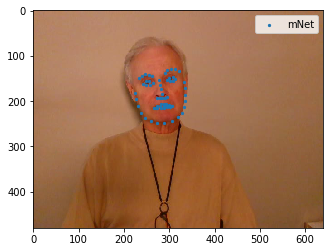

In [14]:
%matplotlib inline
n = 3
plt.imshow(imgs[n].permute(1,2,0)/255)


#plt.scatter(x_fan.iloc[n][1:],y_fan.iloc[n][1:],s=5, label='FAN')
plt.scatter(x_mnet.iloc[n][1:-1],y_mnet.iloc[n][1:-1],s=5, label='mNet')
#plt.scatter(landmarks[n,:,0], landmarks[n,:,1],s=5, color='red')
plt.legend()

In [17]:
csv_name = r'/home/deniz/Code/ClinicalScore/test/A013_02_20190110_NSM_BIGSMILE_mpix.csv'
OLandmarkDataFrame["fps"]=vid[2].get('video_fps')
OLandmarkDataFrame.to_csv(csv_name)

In [28]:
BAG_File = r'/home/deniz/Code/ClinicalScore/test/A013_02_20190110_NSM_BIGSMILE.bag'
info_file = r'/home/deniz/Code/ClinicalScore/test/A013_02_20190110_NSM_BIGSMILE_frameInfoColor.csv'
csv_file = r'/home/deniz/Code/ClinicalScore/test/A013_02_20190110_NSM_BIGSMILE_mpix.csv'

In [41]:
# working get 3D metric values of the 68 landmarks 

def get3dlandmarks(BAG_File, info_file, csv_file):

    DF_landmarks = pd.read_csv(csv_file, index_col=0)

    DF_info = pd.read_csv(info_file, index_col=0)


    # create dataframe to store information about 3d position of landmarks
    df_cols_p1 = ['Time_Stamp (s)']
    for i in range(0, 68):
        num = str(i)
        xx = 'landmark_' + num
        df_cols_p1.append(xx)
        df_cols_p1.append(xx)
        df_cols_p1.append(xx)

    df_cols_p2 = [""]
    for i in range(0, 68):
        df_cols_p2.append("x")
        df_cols_p2.append("y")
        df_cols_p2.append("z")

    header = [np.array(df_cols_p1),
              np.array(df_cols_p2)]

    DF_3dpositions = pd.DataFrame(columns=header)

    DF_3dpositions['Time_Stamp (s)'] = DF_info['Frame_Time_Stamp']
    #DF_3dpositions['Video_Frame_number'] = DF_landmarks['Video_Frame_number']

    # start the process of extracting the video information for each video
    pipeline = rs.pipeline()
    config = rs.config()

    rs.config.enable_device_from_file(config, BAG_File, repeat_playback=False)

    config.enable_all_streams()
    profile = pipeline.start(config)

    # create alignment object
    align_to = rs.stream.color
    align = rs.align(align_to)

    # Getting the depth sensor's depth scale (see rs-align example for explanation)
    depth_sensor = profile.get_device().first_depth_sensor()
    depth_scale = depth_sensor.get_depth_scale()

    # inform the device that this is not live streaming from camera
    playback = profile.get_device().as_playback()
    playback.set_real_time(False)
    duration = playback.get_duration()

    # fill holes in the depth information (based on this example: https://nbviewer.jupyter.org/github/IntelRealSense/librealsense/blob/jupyter/notebooks/depth_filters.ipynb)
    spatial = rs.spatial_filter()
    spatial.set_option(rs.option.filter_magnitude, 2)
    spatial.set_option(rs.option.filter_smooth_alpha, 0.5)
    spatial.set_option(rs.option.filter_smooth_delta, 20)
    spatial.set_option(rs.option.holes_fill, 3)

    true_frame_number = []
    frame_number = []
    time_st = []

    num_frame = 0

    try:
        while True:
            frames = pipeline.wait_for_frames()

            this_frame = frames.get_frame_number()  # get frame number        
            landmarks=None
            # verify that we have landmarks for this particular frame

            try:
                vid_frame = DF_info.Frame_Number_in_Video.loc[DF_info["BAG_Frame_Number"]==this_frame].values[0] 

                index_ = DF_info.index[DF_info['BAG_Frame_Number']==this_frame]

                landmarks = DF_landmarks.iloc[index_].values[0][:-1]
                #print(landmarks)
                landmarks = landmarks.astype('float').reshape(-1, 2)
                aligned_frames = align.process(frames)

                # take color and depth from frame, if any to these is not available then skip the frame
                aligned_frames = align.process(frames)

                # take color and depth from frame, if any to these is not available then skip the frame
                aligned_depth = aligned_frames.get_depth_frame()
                aligned_color = aligned_frames.get_color_frame()

                # validate that both frames are available
                if not aligned_depth or not aligned_color:
                    continue

                #time_stamp = frames.get_timestamp()
                #true_frame_number.append(frames.get_frame_number())
                #time_st.append(time_stamp)
                #frame_number.append(num_frame)

                # Intrinsics & Extrinsics
                depth_intrin = aligned_depth.profile.as_video_stream_profile().intrinsics
                color_intrin = aligned_depth.profile.as_video_stream_profile().intrinsics
                depth_to_color_extrin = aligned_depth.profile.get_extrinsics_to(aligned_color.profile)

                aligned_filtered_depth = spatial.process(aligned_depth)
                depth_frame_array = np.asanyarray(aligned_filtered_depth.as_frame().get_data())
                depth_frame_array = depth_frame_array * depth_scale

                coords = []

                for (c,
                     r) in landmarks:  # landmarks provide the x,y position of each landmark. x are columns and y are rows in the figure
                    # depth_value = depth_frame.get_distance(int(c),int(r))
                    # x,y,z = rs.rs2_deproject_pixel_to_point(depth_intrin, [int(c), int(r)], depth_value)
                    try:
                        depth_value = depth_frame_array[int(r), int(c)]
                    except IndexError:
                        h,w = depth_frame_array.shape
                        if r>w-1:r=h-1
                        if c>h-1:c=w-1
                        depth_value = depth_frame_array[int(r), int(c)]

                    z = depth_value
                    x = z * ((c - depth_intrin.ppx) / depth_intrin.fx)
                    y = z * ((r - depth_intrin.ppy) / depth_intrin.fy)
                    coords.append(x), coords.append(y), coords.append(z)

                DF_3dpositions.loc[index_,1:] =coords
                
            except IndexError:
                error= 'Error file:' + BAG_File.split(os.path.sep)[-1] +'\n' + str(this_frame)+' does not exists in color video'
                print(error)


    except RuntimeError:
        pass
    finally:
        pipeline.stop()
        
    DF_3dpositions['depth_scale'] = depth_scale  
    landmark_file = csv_file[:-4]+'3D.csv'
    DF_3dpositions.to_csv(landmark_file)

In [42]:
get3dlandmarks(BAG_File, info_file, csv_file)

[219.87594604 162.1751709  220.2645874  175.93002319 222.24038696
 191.1711731  226.04956055 207.35644531 233.87905884 222.99645996
 244.15606689 233.57388306 256.87371826 241.62463379 272.73535156
 245.68539429 288.13885498 245.8996582  304.34561157 242.03948975
 318.95751953 233.26763916 327.86077881 222.9213562  333.66455078
 211.95062256 336.80755615 196.72875977 337.9289856  182.43313599
 335.32833862 169.05488586 333.80319214 156.87442017 234.38693237
 141.87564087 242.67230225 138.08728027 251.98880005 135.40164185
 260.27923584 137.00514221 268.0567627  138.31916809 288.32254028
 134.70207214 294.63964844 131.59838867 303.46600342 130.18136597
 312.08624268 132.628479   320.41888428 137.92247009 279.39810181
 150.17155457 280.81585693 159.94438171 283.16674805 170.36209106
 284.72348022 180.09790039 272.262146   190.99926758 277.56292725
 191.98553467 284.11724854 192.0241394  289.6776123  190.77096558
 293.87942505 188.72729492 243.14537048 157.56240845 249.9624939
 155.094131

[221.49411011 167.56886292 224.06213379 183.06210327 227.22377014
 196.59773254 232.00909424 211.72428894 238.80778503 226.94017029
 247.90950012 238.55270386 259.82336426 245.92073059 274.74282837
 248.87509155 291.52719116 247.9412384  307.20568848 243.95553589
 320.91287231 235.258255   328.27981567 225.204422   332.57565308
 213.01716614 333.96209717 200.05760193 334.88342285 186.37921143
 335.07104492 171.30586243 333.65509033 156.9178009  233.09472656
 149.58900452 239.59124756 143.48788452 247.02075195 140.7980957
 254.89012146 141.5009613  263.27630615 143.9309082  288.57684326
 138.39707947 295.19244385 132.63182068 302.91690063 129.78855896
 310.53683472 131.53512573 318.61291504 134.99694824 277.69848633
 154.65585327 279.6685791  163.29545593 281.45623779 174.25593567
 282.49526978 183.45930481 272.35601807 193.00817871 278.04098511
 193.53526306 283.07775879 193.45809937 289.46588135 192.66055298
 295.00366211 190.94378662 242.7935791  161.74873352 249.02386475
 155.878280

[223.38500977 167.80657959 225.48558044 182.60455322 228.05477905
 196.45646667 232.08084106 211.26547241 238.56307983 224.75201416
 248.00764465 236.03642273 260.17028809 243.0582428  274.50622559
 245.75585938 290.29162598 245.32403564 307.13189697 242.23696899
 320.37530518 234.75123596 328.14910889 225.41818237 332.71264648
 213.08856201 334.41345215 198.9455719  334.82739258 185.33422852
 334.56698608 169.09823608 332.92132568 154.54093933 234.70730591
 148.55026245 239.9140625  142.8230896  247.57608032 139.89959717
 255.38386536 140.4236145  262.84118652 142.91140747 290.15316772
 136.29144287 296.82745361 130.90052795 304.19348145 127.95783997
 312.61984253 128.79275513 321.66094971 133.26799011 278.39932251
 153.52038574 280.39196777 162.8874054  282.3828125  173.60498047
 283.44250488 182.64968872 272.54217529 191.52137756 278.74224854
 191.98332214 283.72644043 191.90190125 289.86010742 190.61489868
 294.98059082 188.70063782 243.78477478 161.21838379 249.80671692
 156.05894

[223.38348389 165.41030884 225.10250854 178.79164124 227.92782593
 193.5708313  231.05966187 206.69735718 237.19595337 220.1660614
 246.83496094 233.24650574 258.75274658 241.75938416 273.82971191
 245.44122314 290.77593994 245.48536682 308.37860107 241.01560974
 321.37820435 232.34712219 328.7600708  222.19223022 333.1355896
 210.01092529 334.87362671 195.16183472 335.18228149 182.21755981
 334.62817383 168.35653687 332.73086548 153.56678772 237.40380859
 149.28962708 241.46655273 144.12547302 248.58493042 141.06587219
 255.86505127 141.62477112 262.12161255 143.92887878 290.21630859
 136.66673279 294.52554321 132.956604   301.83032227 129.15916443
 307.29455566 130.81884766 311.99578857 134.602005   278.16018677
 152.95417786 280.46481323 162.54240417 282.24627686 174.29438782
 283.44094849 183.23843384 271.97055054 190.16723633 278.08117676
 191.38143921 284.31860352 191.77316284 289.6086731  189.70298767
 294.42324829 187.1526947  245.94973755 162.47729492 252.40855408
 160.5236663

[223.21203613 168.24102783 224.70127869 182.4319458  227.59048462
 196.44816589 231.94003296 211.10748291 238.73550415 225.66423035
 248.15640259 236.69876099 259.66705322 243.98884583 274.93692017
 247.69284058 291.80810547 246.97117615 308.09014893 242.46269226
 320.88049316 233.73139954 328.24914551 223.4841156  332.56115723
 211.20031738 333.96337891 198.14109802 334.42749023 185.44960022
 334.03936768 170.65087891 331.5847168  154.84890747 234.29957581
 149.33026123 239.74267578 143.81871033 247.673172   140.68539429
 255.43942261 141.48178101 262.80526733 143.48721313 288.29611206
 138.14219666 294.44885254 132.93669128 302.57995605 130.07521057
 310.59368896 132.20599365 317.35614014 136.04666138 277.93585205
 154.3019104  280.19134521 163.44392395 281.95715332 174.31536865
 282.81414795 182.86859131 272.63058472 190.86550903 278.34381104
 191.551651   283.88153076 191.76159668 288.76754761 190.07136536
 292.86422729 188.18896484 243.37921143 161.51556396 249.46769714
 156.75872

[225.31797791 168.07415771 226.20281982 182.55732727 228.50860596
 196.60591125 232.81427002 212.28259277 239.6918335  227.32507324
 248.79553223 238.38394165 260.00393677 244.89379883 275.07104492
 247.9186554  291.65435791 247.35655212 309.57485962 242.98094177
 322.48492432 234.37010193 329.08377075 224.21560669 333.07739258
 211.7755127  334.09625244 198.54780579 334.49359131 184.78543091
 334.3192749  169.84703064 332.23522949 154.62380981 236.12509155
 151.0480957  239.7721405  145.8188324  247.55258179 142.1676178
 254.7698822  142.47450256 260.75640869 144.09585571 290.41680908
 136.95837402 295.84844971 132.78230286 303.71255493 130.31503296
 310.64874268 132.59916687 315.82489014 136.21746826 278.36434937
 153.96572876 280.41680908 162.62310791 282.15515137 173.67901611
 283.21459961 182.56526184 272.65536499 192.52531433 278.18161011
 192.91079712 283.81619263 192.92204285 289.40258789 191.64085388
 293.82110596 189.79798889 244.92922974 163.85960388 251.02815247
 161.610488

[223.05331421 168.85287476 225.23835754 183.67645264 228.15658569
 197.87252808 232.18234253 212.70755005 239.14555359 226.89605713
 249.0539856  237.7600708  261.39489746 244.32165527 275.01757812
 246.75537109 291.61083984 246.46276855 307.7225647  243.14602661
 321.17614746 235.17767334 328.64587402 225.26748657 333.04507446
 213.26269531 334.18365479 200.41967773 334.37216187 186.58007812
 334.24865723 171.0806427  332.53875732 156.65055847 234.13070679
 149.37945557 239.90678406 143.97912598 247.4524231  141.39341736
 255.49584961 142.06600952 263.42926025 143.70828247 290.35379028
 138.05465698 297.00769043 132.70053101 304.574646   129.92160034
 312.9196167  131.69041443 320.16369629 135.54888916 278.91043091
 154.31072998 280.75326538 163.23266602 282.64398193 174.05993652
 283.93676758 183.45169067 272.69818115 192.77105713 278.60888672
 193.04095459 284.04498291 192.90557861 289.88803101 191.92861938
 294.99093628 189.99685669 243.30722046 161.91748047 249.34695435
 156.81930

[223.22137451 167.96658325 225.06478882 182.51597595 227.90126038
 197.1681366  232.32980347 211.93449402 239.15979004 226.17633057
 249.09585571 237.59820557 261.10723877 244.12698364 275.05200195
 246.93951416 291.40380859 246.59860229 307.79388428 242.823349
 320.94940186 234.72868347 328.66638184 224.43962097 332.99197388
 212.13745117 334.18707275 199.37319946 334.75067139 185.6472168
 334.91003418 169.31707764 333.24407959 155.06427002 234.88842773
 148.90068054 240.62329102 142.97924805 248.74249268 139.99404907
 256.693573   140.90625    264.85049438 143.42245483 289.47476196
 138.26586914 296.30773926 132.72052002 303.66882324 129.67785645
 312.42538452 131.01023865 320.3427124  134.31463623 278.69454956
 154.2434082  280.48147583 162.98025513 282.46737671 173.44439697
 283.53436279 182.89323425 273.24267578 192.31443787 279.08624268
 192.70974731 283.9375     192.72976685 289.86917114 191.92010498
 294.84552002 190.16087341 243.3977356  160.68148804 249.68351746
 155.70370483

[222.65133667 165.09114075 223.34434509 178.46833801 225.44233704
 192.47047424 229.20933533 206.93638611 235.46362305 220.77394104
 246.07591248 233.43147278 258.12185669 242.41743469 272.94195557
 248.37565613 290.44213867 249.34750366 307.56890869 244.4234314
 319.89385986 234.62161255 326.85742188 224.27540588 332.41427612
 211.5630188  334.78533936 197.53456116 335.33526611 183.55557251
 334.43478394 168.18043518 331.59786987 154.21905518 235.58413696
 146.75872803 242.10844421 142.29296875 249.41070557 140.51911926
 257.04467773 141.32037354 265.13311768 144.27348328 290.13409424
 138.11457825 296.77716064 132.57058716 305.05239868 129.81208801
 313.5178833  131.46229553 320.77557373 135.31668091 278.77877808
 154.3183136  280.99755859 163.12457275 282.43847656 173.85339355
 283.30108643 183.08177185 270.61721802 189.14370728 277.44915771
 190.74172974 284.36828613 191.38894653 290.75616455 188.99514771
 296.76593018 186.38140869 243.88499451 159.78065491 250.18310547
 155.376632

[223.26568604 163.93608093 223.49298096 177.0930481  225.16546631
 191.02149963 228.29634094 204.79704285 235.47119141 219.6648407
 246.42379761 232.48582458 259.00140381 241.49583435 273.02999878
 246.7046051  290.93841553 247.58093262 309.21984863 241.80180359
 321.32675171 232.31669617 328.3550415  222.21348572 333.47402954
 209.0292511  335.7210083  193.73995972 335.9163208  179.58454895
 334.66394043 166.01501465 332.02679443 153.15420532 236.56724548
 146.04556274 242.87654114 141.19776917 249.82417297 139.30671692
 257.43252563 139.90464783 265.05523682 142.57366943 288.99572754
 137.46113586 295.23184204 132.43981934 303.25738525 128.80154419
 311.73803711 129.80519104 320.01409912 134.08778381 278.72314453
 152.16125488 280.80889893 161.02799988 282.2583313  169.7963562
 283.38064575 179.82337952 271.21679688 185.58274841 277.72982788
 187.62478638 284.27929688 188.09840393 290.42755127 185.64613342
 295.72106934 183.48561096 244.61325073 157.23736572 250.89729309
 153.6389617

[221.29568481 162.62310791 223.06352234 177.50817871 225.32122803
 191.36968994 228.48384094 204.37634277 235.62994385 219.13305664
 246.16549683 232.00930786 258.23709106 240.4012146  272.82440186
 245.97070312 290.12091064 246.36376953 307.86419678 241.52050781
 320.43405151 232.32058716 327.42221069 222.68695068 333.09207153
 209.11901855 334.99298096 195.01559448 334.47387695 179.76239014
 333.1651001  166.05627441 331.03979492 153.32061768 235.25782776
 144.81170654 241.20661926 140.78269958 248.86686707 139.09368896
 256.25634766 139.65675354 264.71795654 142.43292236 288.44967651
 137.17782593 294.23919678 132.40753174 301.96783447 129.07904053
 310.52001953 130.44406128 318.79089355 134.49841309 277.55001831
 151.44250488 279.54806519 160.17532349 281.21398926 170.75698853
 282.30847168 179.6519165  269.58612061 184.9223938  276.07162476
 186.59863281 283.02862549 187.5350647  289.36273193 185.14056396
 294.70983887 182.55206299 242.61026001 156.93148804 249.20120239
 152.81472

[222.5319519  162.5766449  222.5696106  176.27207947 224.82467651
 190.27394104 228.66326904 205.01132202 235.86521912 219.68493652
 246.28431702 231.95259094 258.65588379 241.10287476 273.56811523
 246.76980591 290.66247559 247.27946472 308.81237793 241.20516968
 320.78009033 231.46090698 327.64691162 221.30999756 332.79614258
 207.94471741 334.93060303 193.84230042 334.72338867 179.4460144
 333.2762146  165.66714478 330.69210815 152.75828552 236.57675171
 145.25688171 242.12533569 140.93270874 248.68927002 139.5655365
 255.60302734 139.99580383 263.45788574 142.75932312 287.85461426
 136.79003906 294.28564453 131.61891174 302.581604   128.52005005
 310.48178101 129.72192383 317.9329834  134.21173096 277.70690918
 151.42533875 279.89471436 160.1394043  281.40405273 169.01759338
 282.56219482 179.26300049 269.99664307 184.49163818 276.81689453
 186.54988098 283.47979736 187.14753723 289.38088989 184.71646118
 294.76434326 182.16941833 243.62359619 156.16442871 250.08569336
 152.8688812

[222.33888245 161.50852966 222.84872437 175.35684204 224.87307739
 189.8939209  228.30603027 204.22341919 234.99645996 218.787323
 245.43544006 231.58764648 257.97784424 241.26040649 272.81890869
 246.73977661 289.78741455 247.13464355 308.45623779 241.6156311
 320.39428711 232.11358643 327.44946289 222.06866455 332.98190308
 208.63204956 335.26654053 193.80203247 335.07250977 179.89407349
 333.90130615 165.56570435 331.43688965 152.32345581 236.05993652
 144.87591553 242.2666626  140.47753906 249.56307983 138.72537231
 256.94226074 139.38038635 264.56890869 142.30413818 289.11114502
 136.55168152 295.75384521 131.27841187 303.35928345 128.02207947
 312.29702759 129.19256592 320.91973877 133.81027222 278.61090088
 151.36470032 281.10296631 160.3028717  282.54541016 169.82046509
 283.42300415 179.75823975 270.34844971 185.2048645  277.03005981
 187.14147949 283.93365479 187.50619507 290.65014648 185.20349121
 296.2666626  182.7482605  242.89482117 155.96263123 250.06097412
 152.6856842 

[222.21989441 163.59829712 222.28993225 177.62786865 224.40734863
 191.26953125 228.32763672 205.71517944 234.87539673 219.88052368
 245.16439819 232.18850708 258.42474365 241.57061768 272.95202637
 246.94113159 290.1973877  247.57693481 308.36303711 242.04815674
 320.10397339 233.08401489 327.38311768 222.87173462 332.51861572
 210.51382446 334.84820557 195.94363403 334.90765381 182.1131897
 333.68829346 167.44540405 331.0793457  154.90090942 234.98490906
 146.20733643 240.98303223 141.53897095 248.7114563  139.66571045
 256.01318359 140.139328   263.93777466 142.5774231  287.81787109
 137.37332153 295.13201904 131.87350464 302.80480957 129.01239014
 311.4513855  130.32678223 319.97192383 135.35302734 277.4463501
 152.30796814 279.66867065 161.12796021 281.15795898 170.43069458
 282.13012695 180.21081543 269.85574341 185.48294067 275.73303223
 187.15545654 283.10678101 187.84921265 289.425354   185.67990112
 294.88293457 183.56994629 242.49707031 157.10931396 249.47624207
 153.8165588

[221.21542358 162.24459839 222.00596619 175.90109253 224.41394043
 190.36300659 228.38442993 204.98866272 235.35055542 219.8614502
 246.09988403 232.64103699 258.97839355 242.32218933 273.44940186
 247.94438171 290.37243652 248.51649475 309.17788696 242.56771851
 320.62207031 232.77546692 327.63061523 222.15719604 332.93661499
 209.04402161 335.16656494 194.66020203 335.23034668 180.50135803
 334.08996582 166.04232788 331.69451904 152.74842834 235.18435669
 145.77941895 242.17922974 141.17993164 249.70922852 139.41082764
 256.64807129 140.03604126 264.71112061 142.80871582 288.77157593
 137.19821167 295.10940552 131.95979309 303.61846924 128.53761292
 312.96002197 130.26487732 320.97784424 134.62397766 278.45806885
 152.08222961 280.49407959 160.82565308 281.77813721 170.69444275
 282.70233154 180.3624115  269.90765381 186.24829102 276.54168701
 187.74975586 283.82775879 188.2963562  290.05877686 185.83581543
 295.75646973 183.29197693 242.54037476 157.12133789 249.74188232
 153.425003

[222.70877075 163.07952881 223.6072998  177.12399292 226.08200073
 191.13856506 229.53294373 205.45565796 236.21218872 219.91790771
 246.60166931 232.37481689 258.65585327 241.18432617 273.12850952
 246.6178894  290.18981934 247.59753418 307.9609375  242.25904846
 320.38671875 232.75572205 327.38238525 222.52029419 332.26574707
 210.3706665  333.93908691 197.07167053 333.8263855  181.60577393
 332.96957397 166.72097778 330.85015869 153.01292419 236.19662476
 145.95291138 241.34881592 141.90838623 248.97479248 139.89331055
 256.07550049 140.38928223 263.88806152 142.64576721 289.73745728
 136.57739258 296.0479126  131.58337402 304.05609131 128.11483765
 312.65994263 128.97045898 321.1305542  133.63348389 278.90997314
 151.70196533 281.23901367 160.51828003 282.68991089 170.40023804
 283.48629761 180.03797913 270.49346924 185.63067627 277.17840576
 187.2190094  284.47497559 187.87802124 290.89916992 185.44223022
 296.3694458  182.90501404 242.65310669 157.29142761 249.41430664
 153.25643

[224.1849823  165.71166992 225.30834961 180.0803833  227.88887024
 194.87658691 231.84616089 209.90542603 238.02416992 223.82785034
 247.76652527 235.59524536 259.49798584 243.82455444 275.41098022
 248.51074219 292.88641357 247.99685669 309.91900635 242.13720703
 321.97167969 232.04577637 328.35015869 221.20452881 332.62649536
 208.50552368 334.09106445 194.91311646 334.24673462 181.93011475
 333.59509277 168.48480225 331.47106934 153.17889404 237.39625549
 145.77923584 241.8460083  140.92590332 248.75906372 138.75492859
 256.0062561  138.91555786 263.14254761 140.90353394 289.98455811
 134.80297852 294.86959839 131.8938446  303.49505615 129.71279907
 311.21899414 132.39501953 315.15829468 135.69094849 279.00164795
 151.64837646 281.22094727 160.42991638 283.2953186  170.89584351
 284.3447876  180.19970703 272.48156738 186.60449219 278.6930542
 188.00808716 285.2444458  188.46136475 290.84204102 186.4475708
 295.59936523 184.58041382 244.84909058 159.2481842  250.70733643
 156.2337493

[223.98822021 166.37193298 225.68156433 181.1190033  228.1138916
 195.18855286 231.92803955 209.74336243 238.53068542 224.11003113
 248.68151855 235.49365234 261.59463501 242.51696777 275.79351807
 245.86668396 291.95501709 246.06809998 308.6647644  242.02754211
 320.60180664 234.30133057 327.87161255 224.18182373 332.26818848
 211.59597778 333.58468628 198.24623108 334.10586548 185.22789001
 334.00485229 170.55258179 332.01602173 155.52687073 235.23631287
 148.0582428  241.20153809 142.04985046 248.98153687 139.29092407
 256.980896   139.68388367 263.84182739 141.45619202 289.34631348
 136.60653687 295.34805298 131.33177185 303.98718262 128.00286865
 311.51135254 130.275177   319.05038452 135.67089844 279.3298645
 152.61607361 281.3465271  161.62333679 283.08752441 172.00878906
 283.98114014 180.85522461 273.83370972 190.25079346 279.84307861
 190.22050476 284.65325928 190.21914673 289.9437561  189.2492218
 294.5614624  187.36347961 244.20826721 159.01229858 250.12374878
 155.04634094

[223.68278503 166.28860474 225.43777466 180.84126282 228.10522461
 195.10447693 231.8838501  209.97146606 239.15786743 224.88859558
 249.02758789 236.14801025 261.32116699 242.58430481 275.75720215
 245.20681763 292.40420532 244.8684845  308.91674805 240.88803101
 321.21582031 232.99589539 328.45559692 222.99404907 332.82092285
 210.77885437 334.04754639 197.61468506 334.37469482 183.96481323
 334.2572937  168.79997253 332.10040283 153.97525024 235.59106445
 149.26765442 240.78173828 143.34184265 248.87576294 140.35464478
 256.32949829 140.83674622 263.44763184 142.4745636  290.36242676
 137.13163757 296.85015869 132.53398132 304.58477783 129.99603271
 312.89678955 131.76153564 319.16558838 135.07051086 279.45452881
 152.75793457 281.29724121 161.27401733 283.3807373  172.22714233
 284.57598877 181.03692627 274.15356445 190.75048828 279.99658203
 191.03033447 285.23431396 191.246521   290.60940552 189.95735168
 295.29019165 188.10147095 245.12918091 160.70141602 250.91111755
 157.55020

[222.2003479  165.65048218 224.20849609 180.79110718 227.1399231
 195.34617615 231.4258728  210.13388062 238.63424683 225.25975037
 248.69444275 236.59072876 260.89138794 243.022995   275.68383789
 245.5398407  292.6786499  244.78004456 309.09570312 240.96040344
 320.45715332 233.83764648 327.6857605  223.83631897 332.17486572
 211.54463196 333.40591431 198.39988708 333.75219727 184.7195282
 334.06915283 168.24281311 332.43557739 153.98712158 233.6153717
 146.23335266 240.18139648 141.00210571 248.14294434 139.18249512
 256.12493896 139.58743286 264.18847656 141.77764893 290.90649414
 135.86547852 297.06341553 131.2520752  304.48376465 128.53944397
 312.95843506 130.73724365 321.26950073 135.07469177 279.0741272
 152.65559387 280.94894409 161.23391724 282.78961182 171.27749634
 284.21829224 179.9548645  273.35943604 190.41928101 279.58917236
 190.52220154 284.73764038 190.61039734 290.11013794 189.33061218
 294.81939697 187.51263428 243.2303772  159.10751343 250.06896973
 154.52084351 

[222.14624023 164.78964233 224.77513123 180.13420105 227.09939575
 194.84367371 230.83653259 209.17146301 237.9006958  223.79603577
 248.00088501 235.81684875 260.41772461 242.0644989  275.99533081
 244.7598114  291.98706055 244.5184021  308.17681885 240.81060791
 320.38391113 233.06445312 327.58221436 223.24917603 331.85650635
 211.2984314  333.14813232 198.50102234 333.56188965 185.27339172
 333.70135498 169.52459717 331.85025024 155.28421021 236.27301025
 145.43592834 241.74655151 140.43041992 250.08413696 138.53488159
 257.15823364 139.19029236 265.26263428 141.68997192 289.76898193
 136.45043945 296.37561035 130.845047   304.64794922 127.36395264
 313.31930542 129.43185425 321.51351929 133.71965027 279.11883545
 152.34051514 280.95581055 160.90687561 282.88983154 171.39337158
 284.23413086 180.37762451 273.70111084 190.27119446 279.88180542
 190.39819336 284.99502563 190.37069702 290.57623291 189.31060791
 295.44207764 187.60272217 243.57965088 159.03153992 250.31282043
 154.56813

[221.20852661 162.61157227 222.29016113 176.6763916  224.60946655
 190.58447266 228.15231323 204.66705322 235.09896851 218.88562012
 246.12982178 231.31137085 259.11053467 240.37960815 273.74404907
 245.09533691 290.29000854 245.5027771  307.9230957  240.82672119
 320.19351196 231.9987793  327.6583252  221.89318848 332.99188232
 208.7699585  334.93203735 194.62295532 334.96722412 180.71566772
 333.79327393 165.581604   331.56665039 151.66239929 234.70965576
 145.16999817 241.47015381 140.11776733 248.53518677 137.95677185
 256.84362793 139.0022583  264.54138184 141.63873291 290.79754639
 136.04600525 296.99719238 130.97421265 304.50610352 128.07449341
 313.40338135 129.62710571 322.33001709 133.96710205 279.38290405
 151.87666321 281.40951538 161.36772156 282.73413086 172.3598938
 283.45446777 181.52511597 270.18365479 186.9347229  277.02441406
 188.7671814  284.24432373 189.67678833 290.54180908 187.22988892
 296.1920166  184.69363403 243.20114136 157.62583923 249.46109009
 153.398742

[222.31774902 162.28303528 223.05421448 177.37492371 225.23297119
 191.04164124 228.8661499  205.47045898 235.42449951 220.08514404
 245.73828125 232.42269897 258.47348022 242.37084961 273.13064575
 248.45327759 290.32775879 249.27633667 308.21844482 244.1023407
 320.21966553 234.03347778 327.22518921 223.4919281  332.63354492
 210.28422546 334.77600098 195.59783936 334.79046631 180.93255615
 333.89068604 166.20552063 331.29867554 151.88612366 236.22067261
 145.25791931 241.97828674 141.08747864 248.94302368 139.33021545
 256.19760132 139.91807556 264.6026001  142.54547119 287.95422363
 137.24668884 293.96994019 132.27407837 302.9208374  128.0276947
 311.39074707 129.1946106  318.31607056 133.13853455 277.83480835
 151.76502991 279.90661621 160.58343506 281.63949585 169.76622009
 282.62359619 179.9445343  270.0045166  185.59695435 276.14678955
 187.42572021 283.49603271 188.04380798 290.08340454 185.61569214
 296.25006104 183.30233765 243.10424805 156.27557373 249.72271729
 152.6780090

[221.57096863 162.18618774 222.07728577 177.09680176 224.49746704
 191.19221497 228.70965576 205.79301453 235.79621887 220.93484497
 246.21850586 232.86427307 258.70404053 242.22793579 272.84759521
 248.23138428 290.00894165 248.95944214 308.02337646 243.13824463
 320.28344727 232.25047302 327.12542725 221.20578003 331.95114136
 207.81214905 333.94439697 192.88220215 334.05975342 177.76152039
 333.05969238 164.13604736 330.80651855 151.3177948  233.36758423
 145.58413696 239.80786133 140.54498291 247.06744385 138.70571899
 254.68785095 139.1244812  262.45428467 141.88798523 288.01712036
 135.77667236 294.48284912 130.79852295 302.87942505 127.15361023
 311.67489624 128.73165894 319.13015747 133.36578369 277.21099854
 150.22781372 279.55657959 159.1206665  280.99822998 167.72305298
 282.22097778 177.67802429 269.40753174 183.853302   276.05712891
 185.45321655 283.24493408 186.0071106  289.36755371 183.61155701
 294.59973145 181.47833252 241.32446289 155.88964844 248.50015259
 151.96551

[220.63066101 163.2346344  221.40634155 177.07701111 223.94863892
 191.54096985 228.28549194 206.91690063 235.11080933 221.51116943
 245.84796143 233.95071411 258.42153931 242.74507141 272.33520508
 248.02165222 289.57000732 248.31291199 308.1741333  242.40765381
 319.42211914 232.9979248  326.60089111 222.28109741 331.56112671
 209.63989258 333.75628662 194.55117798 333.88607788 180.84924316
 332.48806763 166.04840088 330.18191528 152.13279724 233.24832153
 144.73048401 239.47763062 139.98554993 246.90357971 137.96786499
 254.66030884 138.73704529 261.72076416 141.15026855 286.68292236
 135.40774536 292.86245728 130.46134949 301.44311523 126.82452393
 309.87841797 127.97497559 317.78491211 132.22076416 276.74530029
 150.59616089 278.72674561 159.25158691 280.22906494 167.88012695
 281.22381592 177.53462219 269.23477173 183.69238281 275.934021
 185.45326233 282.1529541  186.03181458 288.22393799 183.62788391
 293.40719604 181.6362915  241.10766602 155.67919922 247.73519897
 151.9778900

[221.23114014 162.63241577 221.72422791 177.39927673 224.07424927
 191.63040161 228.43795776 207.0279541  234.86503601 221.60868835
 245.37825012 233.97622681 257.35519409 243.22941589 271.04693604
 249.32693481 288.88674927 250.61911011 306.39080811 245.06433105
 318.29455566 234.28953552 325.381073   223.12123108 331.06591797
 209.50244141 333.03494263 195.33998108 333.02133179 181.53192139
 331.98562622 167.31637573 329.24951172 153.30323792 232.95698547
 144.58380127 239.20599365 139.77886963 246.48971558 137.98542786
 253.86468506 138.65718079 262.02249146 141.22921753 287.47192383
 135.07568359 294.04382324 129.74404907 301.76159668 126.9619751
 310.1383667  128.48770142 317.79483032 132.80412292 276.63964844
 150.49403381 278.77471924 159.16854858 280.25952148 167.85931396
 280.79949951 177.49841309 269.24847412 183.66821289 275.54925537
 185.37187195 282.41925049 186.15193176 288.17514038 183.86190796
 293.45663452 181.80677795 241.17990112 155.4906311  247.54649353
 151.672760

[221.78587341 163.41436768 222.25822449 177.93476868 224.77310181
 192.41680908 229.24697876 208.02804565 235.74076843 222.5665741
 246.05831909 234.75213623 258.28930664 243.53918457 272.70239258
 249.37356567 289.60955811 249.97135925 307.64733887 244.19003296
 319.10284424 234.10493469 326.19342041 222.64297485 331.30682373
 209.44190979 333.28338623 194.63928223 333.4753418  179.77822876
 332.60479736 165.72746277 330.24169922 151.31207275 233.23762512
 144.02597046 239.5243988  139.79304504 247.28890991 138.1023407
 254.79281616 138.48864746 262.42953491 140.64529419 287.42767334
 135.73693848 293.96264648 130.48046875 302.65917969 127.01391602
 311.82073975 128.14343262 319.49230957 132.52845764 277.09094238
 150.14898682 279.27767944 159.00637817 280.52856445 167.90133667
 281.38879395 178.16021729 268.55548096 183.82040405 274.92822266
 185.60348511 282.07446289 186.45860291 288.37893677 184.22106934
 293.38952637 182.14556885 241.96325684 155.67524719 248.19848633
 151.9671630

[221.4336853  163.87210083 221.64480591 177.40557861 223.74533081
 192.13644409 228.43151855 208.18511963 235.43768311 222.45669556
 245.81066895 234.66378784 257.4090271  243.72769165 271.85894775
 250.51013184 289.91732788 251.60595703 307.95068359 245.74240112
 319.3039856  235.01541138 326.39590454 223.70523071 331.61566162
 210.71548462 333.5904541  196.4609375  333.84973145 182.17999268
 333.06738281 167.93183899 330.43139648 153.72210693 235.13543701
 145.49874878 240.8311615  141.11605835 248.11184692 139.24055481
 256.07519531 140.06292725 263.97589111 142.79103088 286.14990234
 137.63531494 292.56219482 132.38665771 301.96386719 128.59503174
 309.16247559 131.30523682 314.43884277 135.43203735 277.24237061
 150.953125   278.90332031 159.48934937 280.27807617 168.6086731
 281.33135986 177.98526001 269.14019775 184.99319458 275.37908936
 186.23794556 282.50616455 186.53219604 287.94140625 184.85684204
 293.56060791 182.64086914 243.90582275 157.53326416 249.11254883
 155.413269

[221.3412323  161.86456299 222.22058105 177.17803955 224.45384216
 191.19488525 228.30917358 205.99734497 235.21481323 221.39071655
 245.99639893 233.48986816 258.48382568 243.0539856  272.70111084
 249.38424683 289.85522461 250.55679321 307.31936646 245.69192505
 318.8999939  235.17221069 326.01208496 224.103302   331.35568237
 210.91021729 333.6076355  196.37664795 333.68341064 181.79385376
 332.9197998  167.84115601 330.46173096 153.49629211 235.10876465
 145.07666016 241.31390381 140.70556641 248.3767395  138.89828491
 255.35258484 139.32025146 263.32705688 141.98126221 287.90716553
 136.6187439  294.32275391 131.21867371 303.12506104 127.78992462
 310.921875   129.61805725 316.7598877  133.12835693 278.28216553
 150.55870056 280.10546875 159.98464966 281.20892334 168.84475708
 281.88659668 179.01730347 269.48199463 184.83459473 275.99404907
 186.89358521 282.65454102 187.79547119 288.42950439 185.63494873
 294.05603027 183.75888062 243.36813354 156.75431824 249.31880188
 153.56848

[223.3500061  164.84223938 224.45721436 179.62242126 226.51261902
 193.3724823  229.8197937  208.09507751 236.60861206 223.80148315
 246.35192871 234.96969604 259.01464844 243.33062744 274.91085815
 248.97009277 291.9465332  248.89816284 309.66430664 242.79197693
 321.35089111 232.62887573 327.6126709  221.59365845 332.07116699
 208.48257446 333.77407837 195.05606079 333.84848022 181.98176575
 333.14215088 167.94055176 330.37728882 153.26312256 234.9251709
 147.84825134 240.12333679 142.20773315 248.49606323 139.11688232
 254.92523193 139.47520447 263.14224243 142.29336548 287.62854004
 136.69078064 294.66244507 131.17767334 302.88424683 128.55978394
 310.29458618 131.19348145 315.99111938 135.94812012 277.68334961
 151.24645996 280.13812256 160.14849854 281.86486816 170.00189209
 283.12194824 179.87017822 271.79391479 186.65892029 277.75061035
 187.95620728 284.04812622 188.47377014 289.54345703 186.50361633
 294.82138062 184.6231842  244.46199036 159.8026123  251.0839386
 158.5039978

[222.04811096 163.8533783  224.13842773 179.58097839 226.65515137
 193.82066345 230.68722534 208.14672852 238.00550842 222.70202637
 248.41387939 234.39247131 261.26846313 241.22956848 277.1312561
 244.46948242 292.14544678 244.0635376  308.75650024 239.90460205
 320.34173584 231.48069763 327.57092285 221.13461304 332.02459717
 209.44573975 333.20635986 196.32931519 333.43823242 183.16563416
 333.4413147  167.57409668 331.58331299 152.88482666 235.03533936
 144.17700195 240.30984497 139.48016357 248.58981323 137.8324585
 256.17578125 138.59669495 263.64001465 140.53855896 290.13720703
 135.12030029 296.37695312 130.57341003 304.81622314 127.38925171
 314.07220459 128.89039612 321.39831543 132.48864746 279.11157227
 151.17811584 281.25894165 159.46865845 283.23260498 169.74806213
 284.90237427 178.88375854 273.4336853  188.69599915 279.56225586
 188.93247986 285.12197876 188.99263    290.72955322 187.81640625
 295.66381836 185.86178589 243.54425049 157.92044067 249.95141602
 153.2502288

[222.17541504 164.01400757 224.56890869 179.45352173 227.47967529
 193.93783569 231.33084106 208.77606201 238.2170105  223.0425415
 248.22177124 234.51776123 260.80718994 241.3861084  276.25442505
 244.21560669 291.63873291 243.77651978 308.20211792 240.18432617
 319.89709473 232.68417358 327.25695801 222.58920288 332.27697754
 210.64880371 333.73986816 197.75878906 334.08013916 184.33300781
 334.05297852 168.55999756 331.94082642 153.66123962 234.99179077
 145.21817017 241.14465332 139.95796204 248.9039917  137.66647339
 257.14855957 138.80375671 265.2086792  140.94354248 290.03720093
 135.58905029 296.64825439 130.63461304 304.44888306 127.97336578
 312.58383179 129.33078003 320.6053772  132.90054321 279.77722168
 151.30926514 281.58685303 160.04684448 283.35626221 170.40142822
 284.37982178 179.28839111 273.83978271 189.52658081 279.73962402
 189.95846558 284.84887695 190.09606934 290.66506958 189.06448364
 295.31420898 187.18313599 244.10372925 158.37322998 250.33258057
 153.239181

[222.4646759  164.69668579 224.66897583 180.11187744 227.05488586
 194.5088501  231.25219727 209.4859314  238.30004883 223.91098022
 248.32366943 235.03845215 260.89849854 241.74227905 276.52392578
 244.73348999 292.68243408 244.45825195 309.44372559 240.51922607
 321.5513916  232.2230835  328.65759277 221.79849243 332.79455566
 209.91308594 334.00244141 196.24014282 334.23248291 182.91799927
 333.69769287 167.8354187  331.57171631 152.63900757 235.254776
 147.87646484 240.70742798 141.98310852 249.01635742 139.05056763
 256.61035156 139.48672485 264.57055664 141.60557556 290.30236816
 135.54431152 296.88903809 131.29522705 305.56835938 129.01004028
 313.71844482 131.51376343 318.86300659 135.00518799 279.47549438
 150.9387207  281.76934814 159.9781189  283.71343994 170.20832825
 285.35897827 179.62301636 274.02633667 189.4069519  280.33486938
 189.57077026 285.59991455 189.5546875  291.32232666 188.28692627
 296.45840454 185.90805054 244.96380615 159.46585083 251.14373779
 156.7184753

[222.29849243 162.9776001  223.45550537 178.01325989 225.51298523
 191.52017212 229.53887939 206.28875732 236.46133423 220.03367615
 247.07183838 231.7137146  259.45730591 239.98898315 273.82315063
 245.07055664 289.90023804 245.36560059 306.97729492 240.94763184
 319.64746094 232.80700684 326.92324829 223.1386261  332.12866211
 210.67758179 334.26852417 195.8114624  334.35375977 182.38822937
 333.31207275 167.05613708 331.13699341 152.93783569 237.07342529
 144.82650757 243.40744019 139.80578613 250.50364685 137.94967651
 258.34375    138.89422607 265.88366699 141.41622925 289.51208496
 136.81877136 296.00097656 131.83973694 304.23699951 128.82147217
 311.91424561 130.44589233 319.87063599 133.98475647 279.60754395
 151.58592224 281.49176025 160.64292908 283.05548096 171.26318359
 284.05517578 180.27128601 271.87432861 186.7191925  277.98822021
 188.28684998 284.45672607 189.2479248  290.23419189 187.10298157
 295.82919312 184.8994751  244.54455566 157.89144897 251.28686523
 153.50791

[221.69683838 163.13687134 222.42218018 178.19317627 224.77772522
 191.85105896 229.13644409 206.99380493 235.98326111 221.71440125
 246.40727234 233.64364624 259.15063477 242.49842834 273.69354248
 248.08158875 289.95791626 248.61288452 307.76885986 243.32443237
 319.65835571 233.61618042 326.89208984 222.87983704 331.93328857
 209.75848389 334.17614746 194.66342163 334.45812988 181.13778687
 333.35525513 166.20935059 331.03930664 153.051651   235.60276794
 145.15354919 241.91897583 139.94700623 248.92269897 137.83352661
 257.12997437 138.80274963 264.42486572 141.33253479 288.42749023
 136.27217102 295.0843811  130.82493591 303.60366821 127.41950989
 312.37805176 128.80010986 320.65145874 132.7371521  278.64105225
 151.07522583 280.66784668 160.06881714 281.99291992 168.93487549
 283.03112793 178.98484802 270.58081055 184.82766724 277.6619873
 186.75848389 284.02459717 187.08665466 290.17327881 184.8441925
 295.74719238 182.81044006 243.16340637 157.14802551 249.54812622
 153.1477203

[220.44943237 163.1620636  221.49920654 177.04997253 224.39657593
 191.79046631 228.64230347 207.27709961 234.95483398 221.69544983
 245.08374023 234.53062439 257.37133789 244.63511658 271.37399292
 251.0259552  289.66485596 251.64642334 307.53445435 246.31344604
 318.99517822 235.32095337 325.96237183 223.71870422 331.45446777
 210.08544922 333.63928223 195.65068054 333.92901611 180.95980835
 333.36584473 166.55610657 330.95684814 152.80914307 234.95883179
 144.39619446 241.14178467 139.57704163 248.40084839 137.91482544
 256.05456543 138.93470764 262.97894287 141.71844482 288.36309814
 135.94223022 294.84155273 130.66989136 302.88934326 127.73803711
 310.17098999 128.75427246 318.53753662 132.66271973 278.36831665
 151.85066223 280.05963135 160.18251038 281.31182861 168.65364075
 282.12936401 178.77667236 269.74093628 184.80023193 276.38214111
 186.57029724 283.15734863 187.24386597 289.16253662 184.91575623
 294.62420654 182.91362    242.82225037 156.38395691 248.80781555
 152.62936

[220.97941589 163.42199707 221.09599304 177.39109802 223.44799805
 192.35025024 227.53309631 207.75773621 234.50213623 223.2635498
 244.76803589 234.99162292 256.58679199 244.2724762  270.80914307
 251.27713013 288.47879028 252.60704041 306.66955566 246.09735107
 318.04776001 235.072052   324.95574951 223.84263611 330.56994629
 209.42835999 332.65338135 195.33026123 333.01831055 180.62783813
 332.24685669 166.0634613  329.7081604  151.13760376 232.53448486
 145.43414307 239.34906006 139.52978516 245.97595215 137.30233765
 253.84185791 138.02534485 261.44989014 140.59048462 287.5269165
 135.51179504 293.66680908 130.38279724 302.17901611 127.06854248
 309.30389404 128.53782654 316.49603271 132.24490356 276.96759033
 149.91049194 278.88946533 158.99539185 280.01425171 167.32954407
 280.78033447 176.95173645 268.40722656 184.12896729 274.92321777
 185.48857117 281.76977539 186.0236969  287.96520996 183.93751526
 293.99835205 181.8372345  241.6758728  155.57904053 247.98376465
 151.6551055

[221.52722168 162.79373169 221.71409607 177.02233887 224.06523132
 190.82583618 228.51922607 206.94953918 235.24356079 222.20707703
 245.19619751 234.6530304  257.43389893 244.70681763 270.89526367
 251.72911072 288.37490845 253.30134583 306.17218018 247.60371399
 317.98553467 236.05838013 325.31167603 224.56993103 330.88781738
 210.7272644  333.22906494 196.19517517 333.38262939 181.25682068
 332.72592163 166.97293091 330.45080566 153.35238647 234.1643219
 144.04440308 240.29034424 139.64074707 247.95252991 138.12678528
 255.64624023 139.0294342  263.5345459  141.58969116 287.39672852
 136.52403259 294.37365723 130.81373596 303.25958252 127.52677917
 311.26782227 128.84643555 318.80725098 133.18199158 277.65783691
 150.29541016 279.44464111 159.03353882 280.48449707 167.57611084
 281.1463623  177.01852417 268.77340698 183.98747253 275.06594849
 185.19798279 282.67910767 185.7699585  288.68444824 183.60571289
 294.88830566 181.30435181 241.84933472 156.13252258 248.07926941
 151.657043

[221.69171143 164.33158875 222.28588867 178.53552246 224.17739868
 192.05302429 228.33914185 207.49737549 235.2184906  222.38725281
 245.6388092  234.95175171 256.86791992 244.29466248 270.75616455
 251.71949768 288.81268311 252.88031006 306.46783447 247.05221558
 318.57025146 236.16743469 325.53155518 225.11683655 331.00775146
 211.39300537 333.22857666 197.65037537 333.49835205 183.35174561
 332.97393799 168.96595764 330.59991455 154.26887512 232.87277222
 144.07791138 239.57911682 139.19088745 247.17977905 137.69502258
 255.3256073  138.19450378 262.7109375  140.41645813 287.83831787
 136.17662048 294.54241943 130.50827026 303.15429688 127.34632874
 311.31286621 128.2902832  319.64550781 133.14016724 277.53405762
 150.40116882 279.40313721 159.36529541 280.72906494 168.12304688
 281.73297119 177.46231079 269.07571411 184.45748901 275.32873535
 185.68334961 282.55725098 186.07473755 288.45898438 184.28700256
 294.15478516 181.96315002 241.5411377  155.96614075 247.93032837
 152.02192

[222.09103394 164.59077454 222.43637085 178.10913086 224.35134888
 192.50765991 228.57943726 208.37182617 235.06765747 222.72891235
 245.5854187  234.71520996 257.34429932 244.10998535 270.70346069
 251.41326904 288.43615723 253.06460571 305.55847168 248.23886108
 317.09780884 236.92208862 324.20611572 225.62942505 330.02182007
 211.94799805 332.46060181 197.95327759 332.91522217 184.21621704
 331.9140625  169.09545898 329.3656311  154.79467773 233.88000488
 142.61897278 239.23272705 138.1448822  246.88195801 136.64663696
 254.98214722 137.33563232 262.41748047 140.19523621 287.89950562
 134.96069336 294.07336426 129.72357178 302.78494263 126.1509552
 310.38796997 127.43231964 317.79333496 131.92207336 277.03381348
 149.74687195 279.03179932 159.02819824 280.21844482 167.71060181
 280.98571777 176.8164978  268.78570557 184.23849487 275.13702393
 185.48565674 282.14108276 185.95898438 287.96578979 184.04968262
 293.90933228 181.62762451 241.99494934 155.78381348 248.09921265
 151.986724

[221.85128784 163.99801636 222.20864868 178.71774292 224.08453369
 192.46176147 228.0039978  208.40368652 234.84887695 223.66616821
 245.26435852 235.94915771 257.72137451 245.64749146 271.6293335
 253.04180908 289.42672729 254.34115601 306.3190918  248.25177002
 317.99523926 236.78509521 324.84350586 225.43902588 331.0647583
 211.32315063 333.525177   197.24136353 333.84912109 182.81188965
 333.00354004 167.53283691 330.69296265 152.91082764 234.80764771
 144.82507324 240.68661499 140.09857178 247.9644165  138.14752197
 255.51502991 138.72851562 262.73178101 141.14329529 287.22387695
 136.28277588 294.28887939 130.50198364 303.24417114 127.44189453
 310.70507812 129.19859314 317.48492432 133.41851807 277.58996582
 150.87420654 279.39154053 159.74734497 280.70281982 168.59811401
 281.39807129 178.8711853  269.26141357 185.04751587 275.20410156
 186.59442139 282.28713989 187.44317627 287.97619629 185.33392334
 292.76992798 183.51760864 242.57965088 156.70965576 248.37481689
 153.2557678

[222.31088257 164.56706238 222.66516113 178.570755   224.9473877
 193.18719482 229.21200562 209.37121582 235.74656677 223.84352112
 246.39193726 236.29217529 258.41906738 245.92842102 272.69104004
 252.75234985 290.09881592 253.66438293 306.72235107 248.00947571
 318.05834961 236.90205383 324.69604492 225.76655579 330.47000122
 211.85125732 332.83493042 198.0275116  333.359375   183.64990234
 333.07519531 168.8651886  330.61968994 153.89060974 234.05325317
 146.12785339 240.56695557 140.09268188 247.17962646 137.86096191
 255.26438904 138.13999939 262.84936523 140.86964417 288.73675537
 135.27583313 295.55221558 130.03167725 303.35900879 127.23858643
 310.89389038 128.82394409 318.19329834 133.36404419 277.67401123
 150.56292725 279.73217773 160.02642822 281.24807739 168.90258789
 282.16497803 177.94662476 269.69836426 185.33099365 276.12469482
 186.60092163 282.82342529 187.23196411 288.43737793 185.41012573
 293.93304443 183.12368774 242.89706421 156.6365509  248.96612549
 152.793090

[222.02281189 164.1489563  223.10791016 178.46398926 225.51184082
 193.26132202 229.31028748 208.99658203 235.30647278 223.9977417
 245.41818237 236.68374634 257.96716309 246.75497437 271.8067627
 252.60580444 289.36352539 253.39117432 306.49841309 248.33917236
 318.41723633 238.41134644 325.23443604 227.24658203 330.7890625
 213.47634888 333.11529541 199.45721436 333.64260864 185.35482788
 333.44818115 169.97402954 331.29663086 154.56797791 234.28103638
 145.80368042 241.07128906 140.1374054  248.21229553 137.81445312
 255.26776123 138.14730835 262.82839966 140.3727417  288.88214111
 134.87174988 295.68121338 129.57611084 304.15905762 127.31475067
 311.99017334 129.76681519 318.60919189 134.33355713 278.47744751
 150.81445312 280.36453247 159.84170532 281.6831665  168.61831665
 282.79138184 178.56173706 270.52496338 185.95681763 277.02435303
 187.34985352 283.16937256 188.2260437  288.90411377 186.34637451
 293.56170654 184.58609009 243.35202026 157.04446411 249.12071228
 153.03265381

[222.28312683 163.99755859 223.54171753 179.22854614 226.00561523
 193.48675537 229.36334229 207.59860229 236.24108887 222.54391479
 246.41767883 234.44882202 259.2694397  243.34552002 273.74649048
 248.61791992 289.44735718 249.65481567 307.65570068 244.09420776
 319.74334717 234.18481445 326.45629883 223.83395386 331.25976562
 210.38723755 332.71270752 197.24365234 332.89550781 184.7817688
 332.47967529 169.95166016 330.2772522  154.34539795 234.93830872
 145.19960022 240.94921875 140.2910614  248.93838501 137.6842041
 256.34228516 138.08447266 263.95843506 140.36190796 289.34020996
 134.66281128 296.6897583  129.39285278 304.83276367 127.89741516
 312.73461914 130.37414551 319.46740723 135.08747864 278.90402222
 150.52587891 280.96270752 159.69259644 282.63482666 168.94142151
 283.15917969 178.59356689 271.81915283 186.15637207 277.83050537
 187.22994995 283.80639648 187.72375488 289.35757446 186.2194519
 294.09558105 184.31161499 242.94543457 156.64125061 248.76785278
 153.20593262

[223.40979004 164.64437866 224.92477417 179.89440918 227.5730896
 194.253479   231.41171265 209.27481079 238.26806641 225.08599854
 248.64486694 236.53085327 261.18994141 244.23199463 276.39624023
 248.27502441 292.81945801 248.03533936 309.62426758 242.68307495
 321.10931396 233.60546875 327.54623413 223.15237427 331.89117432
 209.93048096 333.19143677 196.74258423 333.23284912 183.7355957
 333.05633545 168.4307251  331.08337402 153.07260132 235.28710938
 149.08918762 240.36550903 142.45079041 248.69003296 139.1289978
 255.85925293 139.71490479 262.6484375  141.93417358 289.43338013
 135.61627197 295.9604187  131.35067749 303.71463013 129.12472534
 311.7265625  131.72723389 316.59259033 135.66574097 278.73236084
 150.67269897 281.13262939 159.90969849 283.12628174 170.53063965
 284.99169922 180.11343384 272.90185547 188.25973511 278.99328613
 188.89141846 284.73883057 189.15582275 290.37332153 187.85842896
 295.16491699 185.6472168  244.45950317 159.41314697 250.58016968
 157.48362732

[221.94189453 163.67233276 224.44845581 179.96273804 226.60836792
 193.86247253 230.05549622 208.04328918 237.17095947 222.41409302
 247.31472778 234.01942444 260.4286499  241.30114746 275.31719971
 244.99861145 290.85583496 244.98600769 307.32550049 241.12530518
 319.32141113 233.03387451 326.89233398 222.91946411 331.17895508
 210.87887573 332.49273682 197.76431274 332.7454834  185.30767822
 332.73962402 169.82362366 330.71929932 154.60955811 234.47973633
 146.73815918 240.5453186  140.95687866 248.54696655 138.60290527
 256.67532349 139.05012512 263.60299683 141.05323792 289.73828125
 135.41337585 295.66723633 130.77154541 303.96347046 127.8091507
 311.78439331 129.63168335 318.14624023 134.01654053 278.6177063
 151.03927612 280.44476318 159.8309021  282.40472412 170.07086182
 284.09454346 178.55982971 273.60772705 189.9012146  279.58599854
 189.63278198 284.27389526 189.61016846 289.87628174 188.61451721
 294.62985229 186.58728027 244.05886841 158.51654053 249.78240967
 154.1855163

[222.16647339 164.56867981 224.04879761 179.79571533 226.6308136
 194.02220154 230.61602783 208.76654053 237.94345093 223.58834839
 247.85803223 234.55729675 260.72387695 241.28581238 275.91680908
 243.98774719 292.16732788 243.56451416 307.95904541 239.38644409
 319.50219727 231.6464386  326.52389526 221.80410767 331.04315186
 209.57095337 332.49499512 196.81036377 332.95718384 184.04408264
 333.44384766 168.66824341 331.71166992 153.8890686  234.00921631
 145.58399963 239.48873901 140.3513031  247.92053223 137.75263977
 255.88163757 138.1328125  263.94500732 140.79325867 288.96209717
 134.94618225 295.39862061 129.89167786 303.4800415  127.14228821
 311.5965271  128.8583374  319.04168701 132.90284729 278.25164795
 150.9758606  280.13104248 159.23731995 282.15884399 168.61628723
 283.94708252 177.88238525 272.86785889 188.70051575 279.24676514
 188.29026794 284.24359131 187.98753357 289.30114746 187.33929443
 294.14538574 185.73280334 242.88026428 158.24453735 249.00186157
 153.319564

[220.90145874 163.3609314  223.42131042 179.79711914 226.25256348
 194.22657776 230.75915527 209.62559509 237.9760437  224.41215515
 247.765625   235.59243774 260.91207886 242.27151489 275.79614258
 245.58094788 291.16583252 245.23379517 307.44418335 241.52453613
 319.59222412 234.22465515 327.25073242 224.54983521 331.72650146
 212.39472961 333.12072754 198.98175049 333.45739746 185.15988159
 333.44476318 168.85241699 331.57891846 153.64068604 234.42304993
 147.67793274 240.4359436  141.22975159 248.6272583  138.89544678
 256.46331787 139.52388    264.48596191 141.396698   289.57617188
 135.17111206 296.97467041 130.50483704 304.12280273 128.48608398
 313.19543457 130.70129395 320.78649902 135.04853821 278.91650391
 151.05827332 280.67623901 159.66496277 282.26812744 169.21591187
 284.04537964 178.45082092 272.88183594 189.46162415 279.20922852
 189.45307922 284.51599121 189.25270081 289.92358398 188.22673035
 294.57702637 186.60189819 244.62750244 158.91874695 250.5703125
 155.280441

[221.53881836 163.23213196 223.04292297 178.36268616 225.3895874
 193.21685791 228.71417236 208.24378967 235.76153564 223.70579529
 245.86950684 235.71586609 258.24804688 244.33717346 272.48986816
 249.89187622 288.39685059 251.1837616  306.02282715 246.37301636
 318.3493042  237.35192871 325.3739624  226.58872986 330.89074707
 212.26081848 333.07598877 197.98995972 333.81744385 184.39073181
 333.76473999 168.03890991 331.41326904 153.06535339 235.41239929
 144.48620605 241.2756958  139.42765808 248.99963379 137.81661987
 256.3140564  138.63381958 263.61029053 140.90808105 288.13470459
 136.15516663 294.77319336 130.67863464 302.95059204 127.55664825
 310.05685425 129.0585022  317.48046875 133.14929199 278.784729
 151.30001831 280.51812744 160.2164917  282.18191528 169.31277466
 283.51104736 178.51858521 271.94085693 186.36761475 277.93395996
 187.64279175 283.83831787 188.30427551 289.34646606 186.86096191
 294.83822632 185.40681458 244.36398315 156.7487793  249.7411499
 152.94088745 

[222.39984131 164.12167358 223.08044434 178.50402832 225.03952026
 192.42462158 229.16540527 207.87518311 235.70281982 222.49450684
 246.31369019 234.72698975 258.60403442 243.8949585  271.93151855
 249.87841797 288.81219482 251.22827148 305.98355103 246.5798645
 318.02697754 236.19744873 325.09527588 224.91778564 330.45928955
 211.13067627 332.80804443 196.08682251 333.25921631 182.52688599
 332.4833374  166.64868164 330.12438965 152.70574951 235.14056396
 143.80187988 242.03433228 138.69033813 249.09994507 137.3115387
 256.77319336 137.91705322 264.64874268 140.46844482 290.0682373
 134.61280823 296.30627441 130.02914429 304.86187744 126.65998077
 312.27960205 128.33169556 319.93713379 132.96170044 279.27182007
 150.16526794 281.20495605 159.39825439 282.45306396 168.48225403
 283.08294678 178.44210815 270.64447021 184.8609314  277.09136963
 186.55978394 283.33703613 187.57922363 289.34472656 185.52304077
 295.20123291 183.7053833  243.30380249 156.18197632 249.15887451
 152.08529663

[221.14221191 163.39663696 221.67541504 177.76235962 223.625
 192.04573059 228.01887512 207.85754395 235.08956909 223.09179688
 245.62736511 235.57173157 257.84197998 245.24856567 271.61657715
 251.85508728 288.73236084 253.23500061 306.06188965 247.06161499
 318.12988281 235.82164001 325.42294312 224.31027222 330.92486572
 210.44721985 333.27362061 195.54766846 333.57659912 182.51045227
 332.65301514 167.61723328 329.76077271 153.99958801 233.84768677
 142.16531372 239.57449341 138.2678833  247.42602539 136.55264282
 255.46903992 137.19650269 263.1036377  139.86585999 288.02200317
 134.19839478 295.03887939 128.95144653 302.8817749  126.80439758
 310.31170654 128.31596375 317.7913208  132.54974365 277.75170898
 149.58389282 279.71289062 158.07571411 280.97845459 166.43257141
 281.92996216 174.73443604 269.78118896 183.6328125  276.95526123
 184.83030701 282.34017944 185.19433594 288.71343994 183.15869141
 294.22198486 181.51057434 241.70883179 155.40310669 248.17471313
 151.63078308 2

[220.74594116 162.90940857 221.34797668 177.25631714 223.8777771
 192.62411499 227.97348022 207.81085205 234.80889893 223.0645752
 245.12371826 235.09143066 257.35470581 245.16149902 271.28814697
 252.69784546 288.36035156 254.05596924 305.83331299 248.86862183
 317.43878174 237.77801514 324.34014893 226.20904541 329.88027954
 211.8560791  332.36322021 196.82406616 332.59356689 182.22467041
 331.86880493 166.0665741  329.65997314 152.45062256 233.01095581
 143.48539734 240.51403809 138.3359375  247.69406128 136.76895142
 255.84613037 137.34384155 263.28973389 140.15229797 287.21722412
 135.90447998 293.96948242 129.97692871 302.48904419 126.48152924
 310.03369141 128.33139038 317.48516846 132.3302002  277.9881897
 149.43244934 279.65411377 158.00094604 280.72595215 166.53140259
 281.97064209 175.01879883 268.90597534 183.47286987 275.99545288
 184.56112671 282.45172119 185.02932739 288.32958984 183.26556396
 294.41928101 181.36520386 242.21478271 154.82376099 248.47164917
 151.32177734

[220.9846344  163.33319092 221.24794006 177.14358521 223.45526123
 191.4859314  227.8183136  207.68212891 234.74536133 222.28347778
 245.22680664 234.80886841 257.53222656 244.45098877 271.55700684
 251.59161377 289.59576416 252.86260986 306.5892334  247.71572876
 317.74304199 236.63793945 324.59448242 224.78240967 330.25119019
 210.85641479 332.82788086 195.72470093 333.10595703 181.23120117
 332.09738159 166.1774292  329.64355469 152.45040894 232.14279175
 143.61869812 239.34371948 138.7792511  247.29023743 137.07327271
 255.24226379 137.4932251  262.80545044 140.04470825 287.05450439
 134.69758606 294.20080566 129.29832458 301.87548828 126.24710083
 309.30789185 127.5276947  317.04425049 131.49075317 277.01055908
 148.70822144 279.21783447 156.97683716 280.8026123  166.29382324
 281.90335083 175.06549072 269.43841553 183.14041138 276.61889648
 184.68261719 282.25595093 185.01577759 289.1262207  182.82159424
 294.83764648 180.93951416 240.57217407 155.39979553 247.54211426
 150.90521

[220.91119385 164.03819275 221.37399292 178.17254639 223.5355835
 192.38023376 227.73574829 208.5504303  234.47387695 223.59674072
 244.50570679 235.48023987 256.51657104 245.62901306 270.4319458
 253.34606934 288.42010498 254.40174866 306.24835205 248.57502747
 317.78622437 236.83604431 324.8770752  225.03408813 330.86251831
 210.22880554 333.31933594 195.82698059 333.71017456 182.10925293
 332.9468689  166.50219727 330.45431519 151.93280029 233.10438538
 143.51194763 239.77548218 137.99623108 247.57022095 136.34486389
 255.48413086 137.22059631 262.63446045 139.20849609 287.56243896
 135.00971985 294.60101318 129.34658813 302.91705322 126.45214844
 310.43844604 128.13764954 316.74871826 132.1146698  277.9581604
 148.75613403 279.78497314 157.38217163 280.8092041  166.40792847
 282.01989746 175.99942017 268.60293579 184.09202576 275.55767822
 184.97480774 282.92510986 185.30744934 288.99069214 183.35694885
 294.68972778 181.18441772 242.06369019 155.74197388 248.26431274
 151.35128784

[223.21652222 164.93612671 222.88739014 178.02084351 224.5426178
 192.56135559 228.46664429 208.71386719 234.90814209 223.42599487
 245.17802429 235.89552307 257.32629395 246.2059021  271.81402588
 253.84677124 289.34243774 254.98094177 306.71875    248.6289978
 318.78479004 235.8618927  325.34570312 224.19778442 330.97619629
 209.77941895 333.41552734 195.11277771 333.61618042 180.9200592
 332.78671265 167.21961975 329.86651611 152.40937805 235.15675354
 145.384552   241.13208008 140.25361633 248.38012695 138.30310059
 255.5189209  138.89578247 263.35906982 141.93681335 288.30828857
 135.45518494 294.05688477 130.76292419 302.19223022 128.13046265
 309.22634888 131.21180725 313.91378784 135.35357666 277.94927979
 149.92329407 279.45605469 158.45011902 280.60491943 167.87602234
 281.62322998 177.42625427 268.56741333 184.08496094 275.22930908
 185.50723267 282.09344482 186.22909546 288.23400879 184.31274414
 293.97894287 182.36988831 244.45410156 157.08514404 250.23751831
 154.88511658

[223.46893311 165.88447571 224.08621216 181.00476074 225.8293457
 194.71159363 229.32814026 210.69110107 235.90487671 225.63609314
 245.61856079 237.41720581 257.88458252 247.67459106 271.53295898
 253.97842407 289.86212158 254.69987488 307.52008057 247.7408905
 319.21676636 235.91320801 325.77792358 224.79063416 331.44464111
 210.96807861 333.53210449 197.17301941 333.83874512 184.45399475
 333.12652588 169.01017761 330.53723145 153.19613647 236.77520752
 145.60371399 241.80627441 140.48280334 249.08424377 138.61721802
 256.60882568 139.15687561 264.43994141 141.26504517 287.20812988
 136.86581421 293.90930176 131.92079163 302.71221924 128.56512451
 309.55349731 131.12265015 314.21844482 135.38154602 278.72790527
 150.99464417 280.38806152 159.69978333 282.12014771 168.87088013
 283.06326294 178.20153809 271.2911377  186.27679443 276.68737793
 186.8658905  283.66348267 187.25370789 288.6918335  186.08726501
 293.67471313 184.23435974 244.57553101 159.27874756 250.59295654
 156.6300201

[223.26263428 165.11964417 225.05799866 180.23071289 227.5798645
 194.3500824  231.50845337 209.04498291 238.02664185 223.45187378
 247.48301697 234.3792572  259.94006348 242.59300232 274.72833252
 247.35688782 291.19650269 247.95065308 308.11166382 243.81861877
 320.18499756 235.10823059 327.12878418 224.83377075 331.90209961
 211.50982666 333.36651611 198.39289856 333.83978271 186.29524231
 333.71853638 170.50082397 331.56118774 155.22387695 235.88970947
 145.53533936 241.41305542 140.28588867 249.6413269  137.8531189
 257.11016846 138.49771118 264.02587891 140.98200989 289.31219482
 135.41946411 296.45117188 130.42565918 304.65740967 128.03477478
 312.76550293 130.06651306 319.91168213 134.62039185 279.29406738
 150.89445496 281.31872559 159.296875   283.17178345 168.87501526
 284.85256958 178.07107544 273.31524658 186.99981689 279.35766602
 187.77423096 285.00643921 187.782547   290.70062256 186.61451721
 295.53189087 184.71954346 244.84268188 157.9841156  250.71331787
 154.1405639

[222.87368774 163.48745728 224.5909729  178.93521118 227.08406067
 192.96025085 230.35894775 206.59609985 237.99224854 221.35404968
 248.43977356 232.384552   262.18981934 239.57901001 277.13024902
 243.06367493 293.10968018 242.72770691 309.37191772 238.17747498
 321.19213867 229.67826843 328.50238037 219.42524719 332.52963257
 207.56111145 333.640625   195.24987793 333.73568726 181.8235321
 333.14324951 165.23695374 331.03381348 151.84411621 235.79385376
 144.36108398 241.96563721 139.54650879 249.82525635 137.44961548
 258.2689209  138.51959229 265.78839111 141.06404114 290.97338867
 135.46746826 296.81735229 130.9133606  304.80151367 128.06973267
 312.50463867 129.49380493 320.07525635 132.92181396 280.09866333
 150.82702637 281.79992676 159.4934082  283.57672119 169.83758545
 285.21453857 178.28413391 274.23590088 188.29751587 280.56317139
 188.43197632 285.61468506 188.64433289 291.21841431 187.51203918
 295.90106201 185.58641052 245.02223206 157.27789307 250.64727783
 153.174621

[223.22642517 164.02984619 224.64624023 179.22659302 226.72740173
 193.53302002 230.85113525 208.58457947 238.49465942 223.31410217
 248.93991089 234.38233948 262.29458618 241.19606018 277.05169678
 244.27575684 293.05950928 243.95437622 309.08306885 239.78991699
 321.18453979 231.58457947 328.52078247 221.42344666 332.93676758
 209.81542969 334.31311035 196.81173706 334.70404053 183.52706909
 334.08380127 168.10635376 331.46224976 153.1038208  236.42108154
 147.84777832 242.20536804 142.25244141 249.97875977 139.36691284
 257.74401855 140.00772095 265.62164307 142.56295776 290.96673584
 136.56378174 296.77801514 131.89985657 304.81378174 128.76016235
 312.0256958  131.28396606 317.86538696 135.25123596 280.4828186
 151.40655518 282.43951416 159.76089478 284.43704224 169.52618408
 286.47961426 179.41584778 274.47875977 188.58729553 280.90405273
 188.97108459 285.7980957  188.81521606 291.1137085  187.80622864
 296.43585205 185.84359741 246.21014404 158.89929199 251.78088379
 155.309448

[222.22537231 163.38598633 224.44677734 178.78651428 226.98193359
 193.32603455 231.34265137 208.23561096 238.34310913 222.91249084
 248.73825073 234.27488708 261.71157837 240.71194458 276.90896606
 243.70555115 292.62554932 243.26937866 308.68286133 239.47595215
 320.46728516 231.62327576 327.28900146 221.73698425 331.584198
 210.27999878 332.98602295 197.59666443 333.27337646 184.75534058
 333.16778564 169.33432007 330.78771973 154.08197021 234.73980713
 144.84896851 241.42727661 139.64712524 249.42440796 137.73190308
 257.6239624  138.27267456 265.45541382 140.57481384 289.65957642
 135.44276428 296.74230957 130.4949646  304.45855713 127.52822876
 313.26464844 128.93487549 320.79473877 133.23815918 279.4977417
 150.63525391 281.48071289 159.29759216 283.20440674 169.04705811
 284.98052979 178.35517883 274.23065186 188.32992554 280.62252808
 188.55360413 285.31936646 188.42332458 290.89111328 187.15437317
 295.57315063 184.88031006 244.30514526 157.72988892 250.56832886
 153.51390076

[222.33776855 164.34991455 224.35838318 179.70828247 226.77166748
 193.94348145 230.8338623  208.52186584 238.13578796 223.59594727
 248.4753418  235.06744385 261.24136353 241.49305725 276.55859375
 244.52536011 293.43347168 243.83551025 309.01550293 240.06726074
 320.74841309 232.77011108 327.72497559 223.12754822 331.87860107
 211.12045288 333.35546875 197.98512268 333.8989563  184.623703
 333.86785889 169.74464417 331.94094849 155.58126831 234.83352661
 145.04528809 241.82121277 140.14346313 249.45562744 137.97705078
 257.26373291 138.81845093 265.13031006 141.36569214 290.11785889
 136.06085205 296.65301514 130.94961548 305.05163574 127.95957184
 313.81311035 129.25923157 322.78985596 134.46905518 279.70654297
 151.37159729 281.61016846 159.60119629 283.21722412 169.38731384
 284.86749268 178.57217407 273.31072998 188.13702393 279.74832153
 188.60601807 285.02966309 188.59591675 290.69515991 187.84054565
 296.06781006 185.48623657 244.58831787 157.97146606 250.48405457
 153.6473693

[222.1388092  162.84625244 223.3086853  177.45254517 225.35810852
 191.95108032 229.09945679 207.18344116 236.05541992 222.00662231
 246.6631012  233.83473206 259.13751221 242.54977417 273.40600586
 248.30444336 289.62835693 249.29823303 307.0803833  243.84768677
 319.16036987 233.87127686 326.15325928 223.30697632 331.26550293
 210.10237122 333.64907837 195.19389343 334.20925903 182.13809204
 333.46014404 166.89053345 331.00860596 151.86816406 236.77737427
 143.59501648 242.77046204 139.52215576 249.78497314 137.57510376
 257.76275635 138.38006592 265.19564819 141.03442383 288.92877197
 135.64372253 295.89050293 130.7545929  303.93276978 127.71221924
 312.23931885 129.31332397 319.79595947 133.4901123  279.29705811
 150.53756714 281.25469971 159.45776367 282.73266602 169.15310669
 283.68484497 178.74641418 271.29946899 185.16395569 277.85974121
 186.72770691 283.91555786 187.39230347 290.09881592 185.43833923
 295.85357666 183.4511261  245.02706909 156.89164734 250.60888672
 152.77769

[221.44674683 163.55932617 222.14767456 177.31863403 224.43299866
 191.82800293 228.72521973 208.09872437 235.63192749 223.42480469
 246.34506226 235.956604   258.97125244 245.78900146 271.97705078
 252.25592041 289.88458252 253.40170288 307.14175415 247.6763916
 317.81848145 236.28378296 324.80505371 224.14346313 330.48223877
 210.38525391 333.07513428 196.171875   333.30847168 182.36138916
 332.4342041  166.96334839 329.96429443 153.72065735 233.74914551
 143.17900085 240.7644043  138.17016602 247.98165894 136.62197876
 255.99191284 137.12773132 262.84082031 139.72123718 287.60531616
 135.31759644 294.14254761 130.36462402 302.8555603  127.16306305
 310.65496826 128.68942261 317.34210205 132.69374084 277.90380859
 149.84088135 280.09237671 158.38575745 281.55996704 166.89041138
 282.7076416  175.87783813 270.2064209  184.01980591 276.66809082
 185.01696777 283.43029785 185.27096558 289.27017212 183.38012695
 294.94537354 181.17788696 241.79733276 155.51956177 247.82095337
 151.726837

[221.66719055 165.50968933 221.73272705 179.08154297 223.76171875
 193.31671143 228.19288635 209.39419556 235.32174683 224.54420471
 246.1288147  237.03533936 257.77441406 246.28013611 272.18017578
 253.38406372 289.99536133 254.15621948 307.72735596 248.08232117
 318.4833374  237.00294495 324.97177124 225.93511963 330.47338867
 211.26191711 332.79174805 196.77754211 333.16400146 183.63453674
 332.34851074 168.34460449 329.72238159 152.64523315 232.05020142
 145.79782104 238.99371338 139.79016113 246.2102356  137.64631653
 254.79962158 137.85717773 262.08755493 139.94857788 287.79174805
 135.10420227 294.32519531 129.88278198 302.7713623  126.74581909
 310.43408203 128.53619385 316.559021   132.65322876 276.91711426
 149.41741943 278.91607666 158.03723145 280.4230957  166.64186096
 281.58868408 175.23278809 269.67767334 183.77427673 275.91860962
 184.84405518 282.17779541 185.36943054 288.43399048 183.52037048
 294.07989502 181.52865601 241.57104492 155.44044495 247.72848511
 151.90196

[221.00938416 163.44030762 221.1953125  177.64782715 223.00073242
 192.26620483 227.08062744 207.96292114 234.6579895  223.5799408
 245.62438965 236.70681763 257.80569458 246.73815918 272.04553223
 253.94967651 289.68716431 254.81625366 307.2442627  248.470047
 318.10198975 237.01963806 324.62240601 225.64715576 330.06988525
 211.01847839 332.37335205 196.34884644 332.48876953 182.04083252
 331.55114746 166.51548767 328.96957397 151.46101379 232.10394287
 144.99128723 239.67391968 139.17712402 247.09396362 137.14704895
 255.04473877 137.95372009 262.70968628 140.27626038 287.4196167
 135.614151   294.20037842 129.95541382 302.48208618 126.71607971
 310.19802856 127.87757874 317.11425781 131.85688782 277.38995361
 149.13983154 279.05490112 157.87716675 280.33700562 166.66244507
 281.84655762 175.70718384 268.92288208 183.96006775 275.46813965
 184.98422241 282.45037842 185.36529541 288.35858154 183.63024902
 294.01983643 181.61029053 241.50210571 155.3475647  247.70863342
 151.3547821  

[220.71228027 163.16558838 221.03044128 177.74160767 223.49349976
 192.37252808 227.62954712 208.71304321 234.69198608 224.17565918
 245.25047302 236.68057251 257.55374146 246.60943604 271.88571167
 253.54846191 290.28311157 254.29855347 308.11798096 247.89920044
 319.00314331 236.4765625  326.21972656 224.09942627 331.34014893
 210.42578125 333.36541748 196.27194214 333.47683716 181.95211792
 332.22723389 166.26062012 329.30010986 151.39279175 233.26028442
 143.30673218 239.29492188 139.04364014 246.71746826 137.02944946
 255.31758118 137.63058472 262.33529663 140.03274536 287.82855225
 135.59494019 293.94354248 130.41952515 302.25384521 127.57299805
 309.6156311  129.08657837 316.4609375  133.15194702 277.94522095
 149.45251465 279.95062256 158.33848572 281.2666626  166.79272461
 282.1227417  176.43173218 270.15783691 184.39822388 276.33380127
 185.23724365 282.75482178 185.32583618 288.89581299 183.75521851
 294.93164062 181.55810547 242.80053711 155.47573853 248.67092896
 151.06472

[221.8208313  163.18045044 221.76104736 177.29676819 224.12890625
 192.43736267 228.26516724 208.9624176  235.15168762 224.18510437
 245.03323364 236.35253906 256.83416748 246.56369019 271.33557129
 254.2718811  289.57849121 255.32778931 306.7923584  249.90690613
 317.95330811 238.39353943 324.91696167 226.6943512  330.68756104
 212.93238831 332.99078369 198.63037109 333.41397095 184.92662048
 332.20300293 169.88804626 329.29302979 154.72712708 235.75527954
 143.34010315 241.92880249 139.48292542 249.09248352 137.98851013
 256.61663818 138.66712952 263.25036621 140.77838135 287.07159424
 136.1973114  294.28155518 130.56652832 302.4107666  127.75704956
 309.80303955 129.51356506 316.53106689 134.62774658 278.32385254
 150.69529724 280.00598145 159.19247437 280.94549561 168.07380676
 282.06555176 177.30335999 269.02972412 184.99316406 276.03289795
 186.06454468 283.1194458  186.20802307 289.20440674 184.51455688
 295.18444824 182.30622864 243.27737427 156.70884705 248.76202393
 153.77847

[221.19769287 164.1870575  221.42138672 178.05030823 223.27444458
 191.99723816 227.5816803  208.11654663 234.72576904 223.49464417
 245.03065491 236.46656799 257.44906616 246.68080139 271.32550049
 253.8309021  289.13314819 255.29751587 306.63119507 249.28973389
 317.79187012 237.8584137  324.56954956 226.5612793  330.3737793
 212.42259216 332.83798218 197.76931763 333.27389526 183.62788391
 333.02151489 168.97915649 330.98370361 154.27120972 233.86961365
 143.3901062  239.77203369 138.70040894 247.40457153 137.35751343
 255.01647949 138.23829651 262.80065918 140.88200378 288.01083374
 135.36862183 295.42181396 130.15145874 303.12823486 127.81282043
 309.92541504 129.46871948 318.08691406 134.12965393 277.12683105
 149.9924469  279.16137695 158.77552795 280.61056519 167.58616638
 281.94134521 176.42634583 269.16162109 184.38296509 276.04257202
 185.50421143 282.69219971 185.83978271 288.42407227 184.06292725
 293.85345459 182.2051239  242.35269165 156.08930969 248.42498779
 152.421676

[221.79162598 163.36785889 222.06898499 178.40710449 224.22094727
 192.79125977 227.85108948 208.66256714 234.52851868 223.64260864
 245.16506958 236.87887573 256.93078613 247.39019775 270.76507568
 255.30310059 288.49490356 256.19329834 306.14306641 250.587677
 317.52008057 238.89535522 324.46051025 227.60644531 330.29278564
 212.8828125  332.85333252 198.28933716 333.24725342 185.18322754
 332.41833496 169.62963867 330.13775635 154.72976685 233.29806519
 145.10583496 239.98110962 139.80780029 247.0881958  137.78158569
 255.75978088 138.54884338 263.10980225 141.33996582 289.03063965
 135.30175781 295.85314941 129.93911743 303.81790161 127.32817078
 311.19659424 129.17250061 318.137146   134.26138306 277.63961792
 150.20910645 279.41522217 158.74993896 280.60186768 167.49009705
 281.55569458 176.37258911 269.39715576 184.03436279 276.14788818
 185.58120728 282.89294434 185.95346069 289.03717041 184.0512085
 294.63903809 182.340271   242.46658325 155.91894531 248.42684937
 152.04695129

[222.33001709 164.22517395 223.38040161 180.04051208 225.64245605
 193.92085266 229.04095459 209.15936279 235.76113892 224.66822815
 246.43733215 236.69848633 259.04367065 246.08831787 272.65658569
 251.79130554 290.22286987 252.97843933 307.80072021 247.38208008
 318.97259521 236.58085632 325.900177   224.65698242 331.25830078
 210.81913757 333.16729736 197.24598694 333.36828613 184.97058105
 332.66619873 170.14341736 330.42190552 154.90504456 235.14138794
 144.98371887 239.98306274 139.29197693 247.25816345 137.06483459
 256.22546387 137.60142517 263.34820557 140.15704346 288.14630127
 134.927948   295.58624268 130.23057556 303.6550293  127.92410278
 310.38745117 130.78663635 316.25177002 135.52552795 278.51861572
 150.09205627 280.14920044 158.53239441 281.62884521 167.63092041
 282.50024414 177.15371704 270.89520264 184.74414062 276.89160156
 185.42147827 283.22775269 185.82435608 289.09057617 184.47494507
 294.42443848 182.60392761 244.20089722 156.8821106  249.33625793
 154.13586

[221.81738281 163.16801453 223.17796326 177.54977417 225.79806519
 192.604599   229.2964325  207.77946472 235.87768555 223.1598053
 246.09336853 235.27774048 259.2800293  245.04724121 273.20910645
 250.61203003 290.58355713 251.58947754 308.17501831 245.08805847
 320.03179932 233.32374573 326.85144043 221.13677979 331.76464844
 207.55871582 333.48751831 193.58811951 333.39624023 180.48928833
 332.3132019  167.23039246 329.5512085  152.11157227 235.71282959
 145.91313171 240.85986328 140.91104126 248.56149292 137.95951843
 256.29641724 138.31251526 264.42788696 141.5105896  288.55096436
 135.82019043 294.2409668  130.94422913 302.22918701 128.28353882
 309.47125244 130.57038879 314.12561035 135.00238037 278.05969238
 150.26507568 279.93041992 159.15464783 281.80978394 168.29067993
 283.3190918  177.32142639 270.57489014 185.12715149 276.62670898
 185.70509338 283.76647949 186.46356201 289.39257812 185.10446167
 295.45178223 182.99595642 245.31835938 158.9249115  251.83023071
 157.437759

[221.95362854 164.29165649 223.94863892 179.98045349 226.40979004
 193.50605774 229.9569397  207.90731812 237.09449768 222.17399597
 247.74812317 233.06007385 260.99362183 240.75450134 275.97579956
 244.76457214 291.40100098 244.49859619 308.61322021 240.01957703
 320.24737549 232.24783325 326.81140137 222.63131714 331.49206543
 209.79226685 332.91314697 196.75970459 333.23175049 184.73760986
 333.20855713 169.39936829 330.64761353 154.11541748 235.43980408
 145.03004456 241.16592407 140.09225464 248.98782349 138.14111328
 256.7059021  138.62211609 263.99530029 140.74362183 289.71276855
 135.24531555 296.15496826 130.69825745 304.24606323 128.06045532
 312.44900513 129.87765503 318.53857422 133.94419861 278.97885132
 151.34088135 280.85583496 159.64671326 282.54473877 169.44165039
 283.95367432 178.09176636 272.87561035 187.8800354  278.97747803
 188.1693573  284.38452148 188.31712341 290.00323486 186.98187256
 294.92263794 185.07254028 244.85423279 157.86138916 250.18327332
 154.11434

[220.80070496 163.15014648 222.49145508 177.76965332 225.30703735
 192.17555237 229.50660706 206.84503174 236.74171448 221.55847168
 246.5266571  232.15556335 259.52294922 239.14161682 274.66015625
 242.25790405 290.55731201 242.61654663 306.45690918 239.11700439
 319.08551025 231.07727051 326.47128296 222.10327148 331.71859741
 211.28147888 333.79721069 198.41868591 334.04980469 185.00486755
 333.8694458  169.29426575 331.44836426 153.61407471 234.2535553
 147.1930542  240.3901825  141.52993774 249.11087036 139.1532135
 257.35345459 140.13168335 264.80703735 142.84957886 287.83248901
 136.89892578 295.50152588 131.25164795 304.19119263 128.6434021
 312.15884399 130.45306396 318.95599365 135.265625   278.85931396
 151.49171448 280.91229248 160.14627075 282.4942627  169.28088379
 283.71417236 179.1940918  273.05184937 187.89387512 279.20193481
 188.79496765 284.30187988 188.74040222 290.03491211 187.19538879
 294.78344727 185.33177185 244.41729736 157.97987366 250.37110901
 154.7727356 

[222.8812561  164.26252747 225.27406311 180.26234436 227.79423523
 194.48284912 231.82501221 209.24884033 238.73690796 223.15771484
 248.83374023 233.5093689  262.56204224 240.07714844 277.5512085
 242.81674194 292.60772705 242.32832336 307.98779297 238.63786316
 320.0112915  231.22613525 326.92507935 222.44552612 331.58374023
 211.58079529 333.31585693 199.63978577 333.67678833 187.04449463
 333.44720459 171.06225586 331.37597656 155.64707947 235.82077026
 146.88337708 241.66818237 141.16973877 249.61676025 138.94195557
 257.62918091 139.61361694 265.46890259 142.17953491 289.47958374
 135.89697266 296.63525391 130.54216003 304.74621582 127.94989777
 313.1980896  130.34292603 319.25726318 135.14941406 279.59710693
 151.14328003 281.52029419 159.48471069 283.22711182 169.56417847
 284.77212524 178.71965027 273.75717163 188.50291443 280.31958008
 188.80363464 285.30383301 188.83320618 290.66763306 187.45887756
 295.40322876 185.30218506 245.64080811 158.76480103 251.63208008
 155.104660

[221.41635132 163.77720642 223.30145264 180.00210571 225.91889954
 194.20870972 230.6171875  208.83956909 238.55455017 223.31039429
 248.87380981 233.828125   261.60165405 240.3888855  276.65148926
 243.43215942 292.25689697 242.88330078 307.96368408 239.3477478
 319.81738281 232.14022827 327.17593384 222.89596558 332.25497437
 211.28292847 333.87667847 198.20791626 334.21099854 184.90652466
 334.46386719 170.29989624 332.45507812 154.97357178 235.1809082
 146.29859924 240.74230957 141.32183838 248.98342896 138.94262695
 256.78326416 139.22866821 264.25848389 141.26078796 290.12402344
 135.96147156 297.11984253 131.31416321 305.25396729 128.88885498
 313.42385864 131.16836548 320.01806641 135.4186554  279.43154907
 151.31967163 280.8885498  159.89082336 282.48724365 170.71185303
 283.87640381 179.53173828 273.6557312  189.21704102 279.5579834
 189.76864624 284.68280029 189.86975098 289.97399902 188.20172119
 294.32818604 185.98358154 244.34056091 158.83378601 250.34922791
 155.8949585 

[221.6390686  164.45831299 223.86065674 179.15493774 226.58825684
 193.59733582 230.46939087 208.66172791 237.18893433 222.27005005
 247.29830933 233.22489929 260.16119385 239.7346344  275.63803101
 242.78237915 291.73022461 242.34692383 308.3493042  238.12390137
 320.32150269 229.68557739 327.50549316 219.4992981  331.96569824
 207.21556091 333.09365845 194.08192444 333.06689453 180.63934326
 332.23962402 165.68574524 330.09390259 150.85552979 234.42614746
 148.09603882 239.13194275 142.40888977 246.70233154 139.41404724
 254.88781738 139.9684906  262.01126099 142.22676086 289.50411987
 134.97940063 295.43884277 130.66851807 302.70526123 128.33276367
 310.67327881 131.17907715 315.97076416 135.66575623 277.68798828
 150.75457764 280.19830322 159.57278442 281.97766113 169.81858826
 283.20001221 179.45231628 272.809021   188.63154602 278.68951416
 189.0954895  284.09231567 189.29164124 289.40930176 187.94894409
 294.17779541 185.81063843 244.75190735 161.25408936 250.4914856
 159.244491

[222.57141113 164.25222778 223.715271   179.64486694 226.28967285
 193.7490387  230.52972412 208.84016418 237.73641968 223.44688416
 247.22467041 233.61299133 259.64544678 240.21047974 275.29321289
 243.20544434 291.64141846 242.60383606 307.04498291 238.35310364
 320.3210144  230.50222778 327.88470459 220.93927002 332.64904785
 209.51396179 334.19885254 196.73268127 334.50561523 183.71669006
 334.23468018 168.06512451 331.64459229 152.15541077 235.4176178
 149.2096405  240.80908203 144.05413818 249.31137085 140.8134613
 256.18927002 141.28279114 263.95483398 143.42602539 288.7130127
 137.65859985 295.09545898 132.98820496 303.27294922 129.55096436
 311.690979   131.77548218 318.42181396 135.80987549 278.48144531
 153.14881897 280.66290283 161.80477905 282.73016357 172.23350525
 283.80010986 181.18782043 273.39782715 190.17179871 279.06085205
 190.42770386 284.48522949 190.53605652 289.35449219 188.99414062
 293.7131958  187.03575134 245.03842163 160.68458557 250.81088257
 157.86102295

[222.81782532 165.9447937  224.15594482 180.30963135 227.04263306
 194.87954712 231.59251404 210.09344482 238.67636108 224.62887573
 248.58547974 235.36779785 261.51138306 241.83966064 275.98327637
 244.0546875  291.97793579 243.66207886 307.69543457 239.94677734
 319.90374756 232.40240479 326.95953369 223.09667969 331.66073608
 211.84802246 333.1390686  198.90634155 333.32427979 186.4057312
 333.41146851 171.17089844 331.04351807 156.26879883 234.39897156
 149.05635071 240.13442993 142.82550049 247.99569702 139.91824341
 255.89283752 140.36448669 263.24545288 142.54104614 289.87631226
 136.68501282 297.35516357 131.78274536 304.73449707 130.07621765
 313.21942139 132.79803467 319.26141357 137.40734863 279.08456421
 152.84759521 281.17156982 161.66992188 282.73129272 171.94917297
 283.62533569 180.8789978  273.01916504 190.74523926 278.9140625
 190.76950073 284.40542603 190.85305786 290.23059082 189.5793457
 294.81896973 187.57952881 243.36737061 160.7036438  249.87966919
 157.46542358

[223.87930298 168.52243042 225.00634766 182.5579071  227.47891235
 195.86869812 231.41915894 210.28935242 238.24446106 223.98571777
 247.8618927  234.77026367 259.53878784 241.3848114  273.5322876
 244.73684692 289.11920166 244.54490662 306.28619385 240.23300171
 319.1416626  232.32467651 326.63803101 222.79919434 331.40661621
 210.89683533 333.02789307 197.06385803 333.50830078 184.02005005
 333.13800049 168.73191833 330.75860596 152.80764771 233.97239685
 152.36590576 238.40188599 146.3414917  245.89859009 142.20471191
 253.97077942 142.09997559 260.00994873 142.77877808 288.43441772
 136.60946655 294.75405884 132.60638428 301.84310913 130.94288635
 308.56134033 133.60629272 314.79815674 138.25216675 276.80279541
 152.83035278 278.61676025 161.62762451 279.90420532 171.9132843
 281.33773804 181.38909912 271.52008057 190.2396698  276.38598633
 190.90429688 282.26235962 191.36135864 287.78713989 189.79774475
 292.1895752  187.57653809 244.86605835 163.82546997 250.50360107
 161.6294250

In [152]:

def tranform_landmarks(landmarks, centers,scales, resolution, inverse=False):

    
    _pt = torch.tensor([point[0],point[1],1]).view(-1,1).type(torch.FloatTensor)

    h = 200 * scales
    t = torch.eye(3)
    t[:,0,0] = resolution / h
    t[:,1,1] = resolution / h
    t[:,0,2] = resolution *(-centers[:,0]/h + 0.5)
    t[:,1,2] = resolution *(-centers[:,1]/h + 0.5)
    if inverse:
        t = torch.inverse(t)

    return torch.matmul(t,_pt)

(468, 68, 2)

In [120]:
#point = torch.tensor([[1,1,1,1], [2,2,2,2]])
#point = torch.tensor([[1,1,1],[1,1,1]])
point = torch.tensor([[1],[1]])
print(point.shape)
center = torch.tensor([[0,0], [0,0],[0,0],[0,0]])
scale = torch.tensor([0.5,0.5,0.5,0.5])
torch.eye(3).repeat(len(scale),1,1).shape

torch.Size([2, 1])


torch.Size([4, 3, 3])

In [121]:
#point = torch.tensor([[1,1,1,1], [2,2,2,2]])
point

tensor([[1],
        [1]])

In [122]:
torch.tensor([point[0],point[1],1]).view(-1,1)

tensor([[1],
        [1],
        [1]])

In [123]:
resolution = 10

In [124]:
c = tranform_tensor(point, center,scale, resolution, inverse=True)
c.shape

torch.Size([4, 3, 1])

In [125]:
c

tensor([[[-40.0000],
         [-40.0000],
         [  1.0000]],

        [[-40.0000],
         [-40.0000],
         [  1.0000]],

        [[-40.0000],
         [-40.0000],
         [  1.0000]],

        [[-40.0000],
         [-40.0000],
         [  1.0000]]])

In [15]:
centers.shape

torch.Size([200, 2])

In [14]:
landmarks[1,:,:].shape

(68, 2)

In [25]:
a = landmarks[1,:,:].T
a[0].shape

(68,)

In [52]:
scales.shape

torch.Size([200])

In [32]:
x = landmarks[batch,:,0]
y = landmarks[batch,:,1]
for b, i, j in zip(batch, x, y):
    print(b,i,j)

0 [-0.47618791 -0.47312108 -0.45752919 -0.4274694  -0.36568344 -0.28458336
 -0.18422306 -0.05905213  0.06250361  0.19039789  0.30570644  0.37596598
  0.42176616  0.44656894  0.45541847  0.4348956   0.42286009 -0.36167568
 -0.2962923  -0.22277194 -0.15734845 -0.09597282  0.06395307  0.11380407
  0.18345642  0.2514824   0.31723881 -0.00647356  0.00471471  0.02326647
  0.03555135 -0.06278621 -0.02095548  0.03076717  0.07464652  0.10780477
 -0.29255912 -0.23876227 -0.17861591 -0.12761205 -0.17822832 -0.23496354
  0.10625017  0.1465216   0.20067047  0.24669147  0.19654873  0.15025371
 -0.1357829  -0.07932772 -0.0183723   0.04438097  0.09705181  0.15476447
  0.19824749  0.15884146  0.10644237  0.03993902 -0.02459676 -0.07836403
 -0.10318869 -0.02711935  0.03813769  0.10848442  0.17823985  0.11066806
  0.04285809 -0.02727048] [-0.0721626   0.03638265  0.15665698  0.28438184  0.40780377  0.49127477
  0.55480671  0.58685189  0.5885427   0.55808055  0.4888581   0.40721118
  0.32063645  0.2005143

In [59]:
preds_orig[i, j] = np.transform(preds[i, j], center, scale, H, True)

AttributeError: module 'numpy' has no attribute 'transform'

In [24]:
#landmarks = _descale(landmarks,resolution)
%matplotlib qt
plt.plot(np.linalg.norm(landmarks[:,57,:]-landmarks[:,51,:], axis=1),'--o')
    



In [25]:
landmarks.shape

(468, 68, 2)

In [26]:
landmarks[:,:,0].shape

(468, 68)

In [27]:
for x, y in landmarks[:,:,]

SyntaxError: invalid syntax (<ipython-input-27-16c2435fc88f>, line 1)

In [ ]:
def tranform_landmarks(point, center,scale, resolution, inverse=False):

    _pt = torch.tensor([point[0],point[1],1]).view(-1,1).type(torch.FloatTensor)

    h = 200 * scale
    t = torch.eye(3).repeat(len(scale),1,1)
    t[:,0,0] = resolution / h
    t[:,1,1] = resolution / h
    t[:,0,2] = resolution *(-centers[:,0]/h + 0.5)
    t[:,1,2] = resolution *(-centers[:,1]/h + 0.5)
    if inverse:
        t = torch.inverse(t)

    return torch.matmul(t,_pt)

In [49]:
center = 1
scale = 2
resolution = 256
d = landmarks[1,:,:]
tranform_tensor(d[0], center,scale, resolution, inverse=True)

TypeError: object of type 'int' has no len()

In [38]:
t.shape

(2, 68)

In [42]:
t[1][0]

-0.06451475620269775

In [43]:
d = landmarks[1,:,:]

In [47]:
len(d[:])

68

In [ ]:
t = landmarks[1,:,:].T

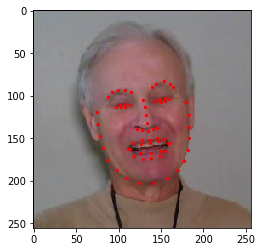

In [28]:
%matplotlib inline
n = 170
plt.imshow(vid_crop[n].permute(1,2,0)/255)
plt.scatter(landmarks[n,:,0], landmarks[n,:,1],s=5, color='red')

#plt.imshow(vid[0][n])

In [ ]:
imgs = vid[0][:,:,:,:]
imgs = imgs.permute(0,3,1,2)

In [ ]:
%matplotlib inline

plt.imshow(imgs[n].permute(1,2,0)/255)


#plt.scatter(x_fan.iloc[n][1:],y_fan.iloc[n][1:],s=5, label='FAN')
#plt.scatter(x_mnet.iloc[n][1:-1],y_mnet.iloc[n][1:-1],s=5, label='mNet')
plt.scatter(original[n,:,0], original[n,:,1],s=5, color='red')
plt.legend()

TypeError: Invalid shape (640, 3, 480) for image data

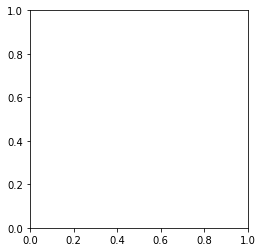

In [30]:
%matplotlib inline
n = 170
plt.imshow(vid[0][n].permute(1,2,0)/255)
plt.scatter(landmarks[n,:,0], landmarks[n,:,1],s=5, color='red')

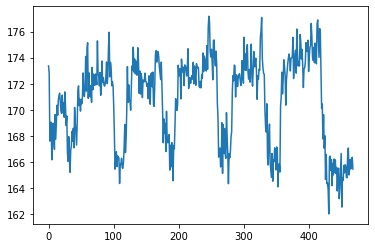

In [29]:
plt.plot(landmarks[:,57,1])

In [ ]:
center = centers
scale = scales

N,C,H,W = imgs.shape
ul_b = tranform_tensor([1,1],center,scale, resolution, inverse = True)
br_b = tranform_tensor([resolution,resolution],center,scale, resolution, inverse = True)
out_imgs = torch.zeros((N,C,resolution,resolution))
for ul_t,bl_t, k in zip(ul_b,br_b, np.arange(N)):
    ul=np.round(ul_t.numpy(),0).astype(np.int)
    br=np.round(bl_t.numpy(),0).astype(np.int)
    newImg = torch.zeros([C,int(br[1]-ul[1]),int(br[0]-ul[0])]).int()
    newX = np.array(
    [max(1, -ul[0] + 1), min(br[0], W) - ul[0]], dtype=np.int32)
    newY = np.array(
    [max(1, -ul[1] + 1), min(br[1], H) - ul[1]], dtype=np.int32)
    oldX = np.array([max(1, ul[0] + 1), min(br[0], W)], dtype=np.int32)
    oldY = np.array([max(1, ul[1] + 1), min(br[1], H)], dtype=np.int32)

    #newImg[:,int(newY[0]) - 1:int(newY[1]), int(newX[0]) - 1:int(newX[1])
    #   ] = image[:,int(oldY[0]) - 1:int(oldY[1]), int(oldX[0]) - 1:int(oldX[1])]

    newImg[:,int(newY[0]):int(newY[1]), int(newX[0]):int(newX[1])] = imgs[k][:,int(oldY[0]):int(oldY[1]), int(oldX[0]):int(oldX[1])]
    out_imgs[k] = nn.functional.interpolate(newImg.unsqueeze(0).float(), size=(resolution, resolution))


In [ ]:
plt.imshow(out_imgs[50].permute(1,2,0)/255)

In [ ]:
F